In [95]:
from pickle import dump,load
import numpy as np
import optuna
from keras.models import Sequential
import os
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error
import time
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [96]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.enable_op_determinism()
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True )
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))

cuda_malloc_async


In [97]:
print("TensorFlow Version:", tf.__version__)
print("CUDA Version:", tf.sysconfig.get_build_info()['cuda_version'])
print("cuDNN Version:", tf.sysconfig.get_build_info()['cudnn_version'])
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow Version: 2.13.1
CUDA Version: 11.8
cuDNN Version: 8
Num GPUs Available:  1


In [98]:
dataset_filtrado_path = 'nuevo_dataset_filtrado.csv'
nuevo_file_path = 'Nivel_Caudal_Asu_Con_1960_2024.csv'
dataset_filtrado = pd.read_csv(dataset_filtrado_path)
nuevo_data = pd.read_csv(nuevo_file_path)
dataset_filtrado['fecha'] = pd.to_datetime(dataset_filtrado['fecha'])
nuevo_data['fecha'] = pd.to_datetime(nuevo_data['fecha'])
columnas_adicionales = ['fecha', 'Qcon', 'Qasu_m']
nuevo_data = nuevo_data[columnas_adicionales]
dataset_combinado = pd.merge(dataset_filtrado, nuevo_data, on='fecha', how='left')
dataset_combinado.info()
dataset_combinado.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19366 entries, 0 to 19365
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   19366 non-null  datetime64[ns]
 1   e010    19359 non-null  float64       
 2   e134    19351 non-null  float64       
 3   e183    19341 non-null  float64       
 4   e218    19337 non-null  float64       
 5   Qcon    19351 non-null  float64       
 6   Qasu_m  19337 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.0 MB


fecha  e010  e134  e183  e218    Qcon  Qasu_m
0 1970-03-14  1.45  1.46  1.19  0.68  1343.6  1350.3
1 1970-03-15  1.45  1.46  1.20  0.73  1343.6  1384.6
2 1970-03-16  1.44  1.46  1.20  0.81  1343.6  1439.1
3 1970-03-17  1.49  1.52  1.25  0.86  1374.0  1472.8
4 1970-03-18  1.49  1.58  1.30  0.86  1404.1  1472.8

In [99]:
dataset_combinado.set_index('fecha',inplace=True)

In [100]:
df_interpolate = dataset_combinado.interpolate(limit = 15, method = 'quadratic', limit_direction = 'both')

In [101]:
df_interpolate.to_csv('df_completo')

In [102]:
df_prueba = pd.read_csv('df_rivers_caudal_1971_07_21_To_2022_11_20.csv')
df_prueba['fecha']= pd.to_datetime(df_prueba['fecha'])
df_prueba.set_index(df_prueba['fecha'],inplace=True)
df_prueba.rename(columns={'valor010':'e010','valor033':'e033','valor088':'e088','valor134':'e134','valor183':'e183','valor211':'e211','e218':'nivel','valor255':'e255'},inplace=True)
df_prueba.drop(columns=['fecha'],inplace=True)
df_prueba['Week_cos'] =  np.cos(2 * np.pi * df_prueba.index.isocalendar().week / 53)
df_prueba['Week_sin'] =  np.sin(2 * np.pi * df_prueba.index.isocalendar().week / 53)

In [103]:
df_prueba

e010  e033  e088  e134  e183  e211  nivel  e255    Qcon  Qasu_m  \
fecha                                                                         
1971-07-21  0.94 -0.18  1.20  1.16  1.16  1.12   1.22  3.08  1189.1  1710.4   
1971-07-22  0.92 -0.19  1.20  1.14  1.12  1.05   1.15  2.95  1178.7  1664.9   
1971-07-23  0.90 -0.20  1.20  1.12  1.10  0.97   1.10  2.85  1168.2  1632.2   
1971-07-24  0.86 -0.21  1.18  1.10  1.04  0.89   1.05  2.74  1157.7  1599.3   
1971-07-25  0.82 -0.22  1.18  1.09  1.02  0.82   1.00  2.65  1152.4  1566.3   
...          ...   ...   ...   ...   ...   ...    ...   ...     ...     ...   
2022-11-16  2.57  2.67  1.55  2.63  3.30  3.28   3.00  4.41  1901.1  2860.6   
2022-11-17  2.57  2.66  1.67  2.85  3.48  3.40   3.13  4.42  1998.0  2950.8   
2022-11-18  2.61  2.65  1.75  3.04  3.58  3.49   3.23  4.42  2079.5  3021.4   
2022-11-19  2.66  2.64  1.77  3.15  3.70  3.58   3.32  4.42  2125.9  3085.8   
2022-11-20  2.66  2.63  1.67  3.16  3.77  3.66   3.40  4.42  2130.1  3144.0   

            Week_cos  Week_sin  
fecha                           
1971-07-21 -0.956401 -0.292057  
1971-07-22 -0.956401 -0.292057  
1971-07-23 -0.956401 -0.292057  
1971-07-24 -0.956401 -0.292057  
1971-07-25 -0.956401 -0.292057  
...              ...       ...  
2022-11-16  0.674983 -0.737833  
2022-11-17  0.674983 -0.737833  
2022-11-18  0.674983 -0.737833  
2022-11-19  0.674983 -0.737833  
2022-11-20  0.674983 -0.737833  

[18751 rows x 12 columns]

In [104]:
#datos_norm = df_interpolate.copy() # Copia del dataframe 
#datos_norm['Week_cos'] =  np.cos(2 * np.pi * datos_norm.index.isocalendar().week / 53)
#datos_norm['Week_sin'] =  np.sin(2 * np.pi * datos_norm.index.isocalendar().week / 53)
#datos_norm['Month'] = datos_norm.index.month
#datos_norm['Month_sin'] = np.sin(2 * np.pi * datos_norm.index.month / 12)
#datos_norm['Month_cos'] = np.cos(2 * np.pi * datos_norm.index.month / 12)
#datos_norm['Year'] = datos_norm.index.year
#datos_norm.rename(columns={'e218':'nivel'},inplace=True)
#horizonte = 28 # Cantidad de días a predecir
#tamanio_ventana = 365 # Datos de niveles de los últimos días para la predición
#cantidad_unidades = 30 # Cantidad de neuronas
#tamanio_batch = 30 # Tamaño del batch
#dropout = 0.25 # Probabilidad para desactivar una neurona
#features_set = 1 # Posición de características para el entrenamiento
#year_ini = 73 # Año inicial
#arch = 'GRU' # Arquictura del modelo
#modelo = arch+'_h'+str(horizonte)+'_w'+str(tamanio_ventana)+'_u'+str(cantidad_unidades)+'_d'+str(dropout)+'_f'+str(features_set)+'_y'+str(year_ini)

In [105]:
#datos_norm.to_csv('df_final')

In [106]:
def preparar_datos(tamanio_ventana,horizonte, data): # Función para la división datos para el entrenamiento
    n_features=len(data.columns)
    x_train = np.zeros((len(data)-tamanio_ventana-horizonte+1,tamanio_ventana, n_features))
    y_train= np.zeros((len(data)-tamanio_ventana-horizonte+1, horizonte ))
    for i in range(tamanio_ventana, len(data)-horizonte +1):
        x_train[(i-tamanio_ventana), :, :] = data.iloc[(i-tamanio_ventana):(i), :]
        y_train[i-tamanio_ventana, :] = data['nivel'].iloc[(i):(i+horizonte)]
    return x_train,y_train

In [107]:
def create_model(trial, tamanio_ventana, cantidad_unidades, nfeatures, dropout, horizonte, lossF):
    model = keras.Sequential()
    model.add(
              tf.keras.layers.Bidirectional(
                                            tf.keras.layers.GRU(
                                                                cantidad_unidades, 
                                                                input_shape=(tamanio_ventana, nfeatures)
                                                                )
                                             )
            )
    model.add(tf.keras.layers.Dropout(rate=dropout))
    model.add(tf.keras.layers.Dense(horizonte))
    model.compile(optimizer='adam', loss=lossF, metrics=[RootMeanSquaredError()])
    return model

In [109]:
orden=['nivel','e010','e033','e088','e134','e183','e211','e255','Qcon','Qasu_m','Week_cos','Week_sin']
datos_norm=df_prueba[orden]
datos_norm.isnull().sum()

nivel       0
e010        0
e033        0
e088        0
e134        0
e183        0
e211        0
e255        0
Qcon        0
Qasu_m      0
Week_cos    0
Week_sin    0
dtype: int64

In [110]:
datos_norm

nivel  e010  e033  e088  e134  e183  e211  e255    Qcon  Qasu_m  \
fecha                                                                         
1971-07-21   1.22  0.94 -0.18  1.20  1.16  1.16  1.12  3.08  1189.1  1710.4   
1971-07-22   1.15  0.92 -0.19  1.20  1.14  1.12  1.05  2.95  1178.7  1664.9   
1971-07-23   1.10  0.90 -0.20  1.20  1.12  1.10  0.97  2.85  1168.2  1632.2   
1971-07-24   1.05  0.86 -0.21  1.18  1.10  1.04  0.89  2.74  1157.7  1599.3   
1971-07-25   1.00  0.82 -0.22  1.18  1.09  1.02  0.82  2.65  1152.4  1566.3   
...           ...   ...   ...   ...   ...   ...   ...   ...     ...     ...   
2022-11-16   3.00  2.57  2.67  1.55  2.63  3.30  3.28  4.41  1901.1  2860.6   
2022-11-17   3.13  2.57  2.66  1.67  2.85  3.48  3.40  4.42  1998.0  2950.8   
2022-11-18   3.23  2.61  2.65  1.75  3.04  3.58  3.49  4.42  2079.5  3021.4   
2022-11-19   3.32  2.66  2.64  1.77  3.15  3.70  3.58  4.42  2125.9  3085.8   
2022-11-20   3.40  2.66  2.63  1.67  3.16  3.77  3.66  4.42  2130.1  3144.0   

            Week_cos  Week_sin  
fecha                           
1971-07-21 -0.956401 -0.292057  
1971-07-22 -0.956401 -0.292057  
1971-07-23 -0.956401 -0.292057  
1971-07-24 -0.956401 -0.292057  
1971-07-25 -0.956401 -0.292057  
...              ...       ...  
2022-11-16  0.674983 -0.737833  
2022-11-17  0.674983 -0.737833  
2022-11-18  0.674983 -0.737833  
2022-11-19  0.674983 -0.737833  
2022-11-20  0.674983 -0.737833  

[18751 rows x 12 columns]

In [111]:
from itertools import combinations
feat = ['e134','e183','e010','Qcon','Qasu_m','Week_cos','Week_sin','Month','Month_sin','Month_cos','Year']
all_combinations = []
for r in range(1, len(feat) + 1):
    combinations_r = combinations(feat, r)
    all_combinations.extend(combinations_r)
all_combinations_as_lists = [list(comb) for comb in all_combinations]
len(all_combinations_as_lists)

2047

In [116]:
def create_objective(datos_norm):
    def objective(trial):
        # Optimización de parámetros
      
        features_set = trial.suggest_categorical('features', [0,1,2,3,4,5])
        
        # Definición de otros parámetros
        year_ini = 73  # Puedes definir o ajustar según tus necesidades
        tamanio_ventana= 365 
        horizonte = 28  # Valor fijo según tu comentario anterior
        cantidad_unidades = 30  # Valor fijo según tu comentario anterior
        tamanio_batch = 128  # Valor fijo según tu comentario anterior
        dropout = 0.25  # Valor fijo según tu comentario anterior
        lossF = 'mean_squared_error'  # Valor fijo según tu comentario anterior
        initial_learning_rate = 0.001  # Valor fijo según tu comentario anterior
        seed = 42
        tf.random.set_seed(seed)
        np.random.seed(seed)
        # Selección de características según features_set
        lista = [   ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m'],
                    ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m','Week_cos','Week_sin'],                 
                    ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m','Week_cos','Week_sin','e010'],
                    ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m','Week_cos','Week_sin','e033'],
                    ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m','Week_cos','Week_sin','e088'],
                    ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m','Week_cos','Week_sin','e010','e033','e088'],
                ]
        
        datos = datos_norm[lista[features_set]]
        nfeatures = len(datos.columns)
        
        desde = (dt.datetime.strptime('19'+str(year_ini)+'-01-01', '%Y-%m-%d') - dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')        
        # Normalización de los datos
        Scaler = MinMaxScaler()
        Scaler.fit(datos.loc[desde:'2022-11-20'])
        ix = datos.index
        datos_normm = pd.DataFrame(Scaler.transform(datos), columns=datos.columns)
        datos_normm.set_index(ix, inplace=True)
        
        Rmse = []
        Dtime = []
        maxError = []
        epocash = []
        Error_95 = []
        r2 = []
        hist = []
        
        for valyear in [2017, 2018, 2019]:
            print(f'Validation year: {valyear}')
            
            trainScaled = datos_normm.loc[desde:str(valyear - 1) + '-12-31']
            x_train, y_train = preparar_datos(tamanio_ventana, horizonte, trainScaled)
            
            desde = (dt.datetime.strptime(str(valyear) + '-01-01', '%Y-%m-%d') - dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d')
            valScaled = datos_normm.loc[desde:str(valyear) + '-12-31']
            x_val, y_val = preparar_datos(tamanio_ventana, horizonte, valScaled)
            
            epocas = 15
            
            model = create_model(trial, tamanio_ventana, cantidad_unidades, nfeatures, dropout, horizonte, lossF)
            
            early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
            lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
            callbacks_list = [early_stopping, lr_scheduler]
            
            start_time = time.time()
            model.reset_states()
            
            history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epocas, batch_size=tamanio_batch, verbose=1, callbacks=callbacks_list)
            
            Y_prediction = Scaler.inverse_transform(np.hstack(((model.predict(x_val).reshape(-1, 1), np.zeros((np.size(y_val), nfeatures - 1))))))[:, 0]
            y_val_inv = Scaler.inverse_transform(np.hstack(((y_val.reshape(-1, 1), np.zeros((np.size(y_val), nfeatures - 1))))))[:, 0]
            
            mse = mean_squared_error(y_val_inv, Y_prediction)
            rmse = np.sqrt(mse)
            error = np.abs(y_val_inv - Y_prediction)
            Error_95_ = np.percentile(error, 95)
            maxError_ = max_error(y_val_inv, Y_prediction)
            r2_ = r2_score(y_val_inv, Y_prediction)
            
            print(f"MSE: {mse} RMSE: {rmse}")
            print(f"MaxError: {maxError_} R2: {r2_} Error95: {Error_95_}")
            
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Time step: {elapsed_time:.6f} seconds")
            
            Rmse.append(rmse)
            Dtime.append(elapsed_time)
            maxError.append(maxError_)
            Error_95.append(Error_95_)
            epocash.append(len(history.history['loss']))
            r2.append(r2_)
            hist.append(history)
            
            if len(history.history['loss']) < epocas * 0.2:
                continue
        
        avg_score = np.mean(Rmse)
        avg_Error_95 = np.mean(Error_95)
        
        print(f"Avg RMSE: {avg_score}, Avg Error95: {avg_Error_95}")
        
        trial.set_user_attr("mean_rmse", avg_score)
        trial.set_user_attr("Error95_mean", avg_Error_95)
        
        return avg_score, avg_Error_95

    return objective

In [117]:
SEED = 42
study =optuna.create_study(directions=['minimize','minimize'],sampler=optuna.samplers.TPESampler(seed=SEED))
objective = create_objective(datos_norm)

[I 2024-07-10 16:22:27,608] A new study created in memory with name: no-name-8d22cbf5-cd38-40d1-bc62-a2a583e81b18


In [118]:
study.optimize(objective, n_trials=100, n_jobs=2)

Validation year: 2017
Validation year: 2017
Epoch 1/15
Epoch 1/15
126/126 [==============================] - 27s 123ms/step - loss: 0.0485 - root_mean_squared_error: 0.2203 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0892 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 27s 124ms/step - loss: 0.0491 - root_mean_squared_error: 0.2215 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0794 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 13s 105ms/step - loss: 0.0109 - root_mean_squared_error: 0.1045 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0661 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 13s 105ms/step - loss: 0.0117 - root_mean_squared_error: 0.1080 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 14s 111ms/step - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589 - lr: 0.0010
Epoch

2024-07-10 16:24:55.418381: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: Expected begin, end, and strides to be 1D equal size tensors, but got shapes [1], [11,1], and [1] instead.


126/126 [==============================] - 7s 54ms/step - loss: 0.0039 - root_mean_squared_error: 0.0622 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0495 - lr: 0.0010
Epoch 11/15
126/126 [==============================] - 7s 54ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461 - lr: 0.0010
Epoch 11/15
126/126 [==============================] - 6s 50ms/step - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0487 - lr: 0.0010
Epoch 12/15
126/126 [==============================] - 6s 50ms/step - loss: 0.0036 - root_mean_squared_error: 0.0602 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446 - lr: 0.0010
Epoch 12/15
126/126 [==============================] - 6s 50ms/step - loss: 0.0035 - root_mean_squared_error: 0.0590 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0483 - lr: 0.0010
Epoch 13/15
126/126 [==============================] - 6s 50ms/step - loss: 0

[I 2024-07-10 16:26:05,259] Trial 0 finished with values: [1.6553188017109577, 3.313146424969038] and parameters: {'features': 1}. 


MSE: 5.533471597990385 RMSE: 2.352333224267001
MaxError: 8.254384403228759 R2: -0.11150211584111802 Error95: 4.775598887443543
Time step: 15.337582 seconds
Avg RMSE: 1.6553188017109577, Avg Error95: 3.313146424969038
Validation year: 2017
11/11 [==============================] - 1s 14ms/step


[I 2024-07-10 16:26:05,966] Trial 1 finished with values: [1.5628570530473078, 2.89887557609876] and parameters: {'features': 0}. 


MSE: 5.513281492963018 RMSE: 2.348037796323351
MaxError: 6.375060443878174 R2: -0.1074465525189674 Error95: 4.521489486694335
Time step: 15.857633 seconds
Avg RMSE: 1.5628570530473078, Avg Error95: 2.89887557609876
Validation year: 2017
Epoch 1/15
Epoch 1/15
126/126 [==============================] - 12s 41ms/step - loss: 0.0462 - root_mean_squared_error: 0.2148 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 44ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0646 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 16s 67ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 49ms/step - loss: 0.0082 - root_mean_squared_error: 0.0905 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597 - lr: 0.0010
Epoch 

[I 2024-07-10 16:28:17,634] Trial 2 finished with values: [1.6322466283746226, 3.133656424164773] and parameters: {'features': 1}. 


MSE: 4.981317174720144 RMSE: 2.231886460983207
MaxError: 6.777908172607422 R2: -0.000591487880401198 Error95: 4.315408976554872
Time step: 11.202097 seconds
Avg RMSE: 1.6322466283746226, Avg Error95: 3.133656424164773
Validation year: 2017
3/3 [==============================] - 7s 587ms/step - loss: 0.4245 - root_mean_squared_error: 0.6515 - val_loss: 0.2840 - val_root_mean_squared_error: 0.5329 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 81ms/step - loss: 0.3407 - root_mean_squared_error: 0.5837 - val_loss: 0.2167 - val_root_mean_squared_error: 0.4655 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 74ms/step - loss: 0.2716 - root_mean_squared_error: 0.5212 - val_loss: 0.1609 - val_root_mean_squared_error: 0.4012 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 75ms/step - loss: 0.2138 - root_mean_squared_error: 0.4623 - val_loss: 0.1166 - val_root_mean_squared_error: 0.3415 - lr: 0.0010
Epoch 5/15
3/3 [==========================

[I 2024-07-10 16:28:24,063] Trial 3 finished with values: [1.4903409071228102, 2.8868970652421324] and parameters: {'features': 3}. 


MSE: 5.097342844217177 RMSE: 2.2577295773004296
MaxError: 7.119601507186889 R2: -0.023897431509834588 Error95: 4.4327085280418395
Time step: 11.368429 seconds
Avg RMSE: 1.4903409071228102, Avg Error95: 2.8868970652421324
Validation year: 2017
126/126 [==============================] - 12s 52ms/step - loss: 0.0524 - root_mean_squared_error: 0.2289 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 45ms/step - loss: 0.0117 - root_mean_squared_error: 0.1083 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 13s 56ms/step - loss: 0.0558 - root_mean_squared_error: 0.2363 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 7s 52ms/step - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0585 - lr: 0.0010
Epoch 4/15
126/126 [==

[I 2024-07-10 16:30:26,929] Trial 4 finished with values: [1.4700506883210454, 2.7296379786332454] and parameters: {'features': 0}. 


MSE: 3.9492824086807543 RMSE: 1.98728015354674
MaxError: 6.712774667739867 R2: 0.20671215609076787 Error95: 3.7804988842010503
Time step: 10.326531 seconds
Avg RMSE: 1.4700506883210454, Avg Error95: 2.7296379786332454
Validation year: 2017
3/3 [==============================] - 7s 521ms/step - loss: 0.4878 - root_mean_squared_error: 0.6985 - val_loss: 0.3258 - val_root_mean_squared_error: 0.5708 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 74ms/step - loss: 0.3983 - root_mean_squared_error: 0.6311 - val_loss: 0.2595 - val_root_mean_squared_error: 0.5094 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 76ms/step - loss: 0.3297 - root_mean_squared_error: 0.5742 - val_loss: 0.2048 - val_root_mean_squared_error: 0.4526 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 76ms/step - loss: 0.2647 - root_mean_squared_error: 0.5144 - val_loss: 0.1600 - val_root_mean_squared_error: 0.4000 - lr: 0.0010
Epoch 5/15
3/3 [==========================

[I 2024-07-10 16:30:37,095] Trial 5 finished with values: [1.4880532365549477, 2.839582820018132] and parameters: {'features': 2}. 


MSE: 3.4563562841073274 RMSE: 1.8591278288776507
MaxError: 5.959058847427366 R2: 0.30572566338259266 Error95: 3.651364447116851
Time step: 13.381529 seconds
Avg RMSE: 1.4880532365549477, Avg Error95: 2.839582820018132
Validation year: 2017
126/126 [==============================] - 10s 46ms/step - loss: 0.0436 - root_mean_squared_error: 0.2087 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0821 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 38ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0593 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 6s 44ms/step - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0549 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - 13s 64ms/step - loss: 0.0485 - root_mean_squared_error: 0.2202 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873 - lr: 0.0010
Epoch 2/15
126/126 [=====

[I 2024-07-10 16:32:40,547] Trial 6 finished with values: [1.7411596237734799, 3.2477703656355543] and parameters: {'features': 5}. 


MSE: 7.270286878274423 RMSE: 2.6963469506490485
MaxError: 6.739960603713989 R2: -0.46037421623501773 Error95: 5.03219318151474
Time step: 12.706245 seconds
Avg RMSE: 1.7411596237734799, Avg Error95: 3.2477703656355543
Validation year: 2017
3/3 [==============================] - 7s 555ms/step - loss: 0.3564 - root_mean_squared_error: 0.5970 - val_loss: 0.2411 - val_root_mean_squared_error: 0.4910 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 79ms/step - loss: 0.2897 - root_mean_squared_error: 0.5383 - val_loss: 0.1866 - val_root_mean_squared_error: 0.4319 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 81ms/step - loss: 0.2295 - root_mean_squared_error: 0.4791 - val_loss: 0.1422 - val_root_mean_squared_error: 0.3771 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 76ms/step - loss: 0.1793 - root_mean_squared_error: 0.4235 - val_loss: 0.1074 - val_root_mean_squared_error: 0.3277 - lr: 0.0010
Epoch 5/15
3/3 [==========================

[I 2024-07-10 16:32:51,751] Trial 7 finished with values: [1.4705468120832974, 2.771382219243932] and parameters: {'features': 4}. 


MSE: 4.1873209372228235 RMSE: 2.046294440500395
MaxError: 6.674700279235839 R2: 0.15889762890998238 Error95: 3.7930991711616513
Time step: 14.025444 seconds
Avg RMSE: 1.4705468120832974, Avg Error95: 2.771382219243932
Validation year: 2017
126/126 [==============================] - 11s 45ms/step - loss: 0.0497 - root_mean_squared_error: 0.2230 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 4s 34ms/step - loss: 0.0130 - root_mean_squared_error: 0.1142 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0614 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 8s 62ms/step - loss: 0.0089 - root_mean_squared_error: 0.0941 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - 15s 69ms/step - loss: 0.0529 - root_mean_squared_error: 0.2300 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0842 - lr: 0.0010
Epoch 2/15
126/126 [=====

[I 2024-07-10 16:34:56,426] Trial 8 finished with values: [1.4904316036817804, 2.820434933503469] and parameters: {'features': 4}. 


MSE: 4.353648424818196 RMSE: 2.086539821047803
MaxError: 5.967057905197143 R2: 0.12548761656765184 Error95: 3.9496216816902163
Time step: 15.609692 seconds
Avg RMSE: 1.4904316036817804, Avg Error95: 2.820434933503469
11/11 [==============================] - 3s 199ms/step
MSE: 5.1570769618090475 RMSE: 2.270919849270125
MaxError: 6.304578395485878 R2: -8.119968647055606 Error95: 4.238579108238223
Time step: 17.690937 seconds
Validation year: 2019
Epoch 1/15
Epoch 1/15
3/3 [==============================] - 7s 709ms/step - loss: 0.5440 - root_mean_squared_error: 0.7375 - val_loss: 0.3593 - val_root_mean_squared_error: 0.5994 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 98ms/step - loss: 0.4466 - root_mean_squared_error: 0.6683 - val_loss: 0.2887 - val_root_mean_squared_error: 0.5373 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 2s 857ms/step - loss: 0.3705 - root_mean_squared_error: 0.6087 - val_loss: 0.2321 - val_root_mean_squared_error: 0.4818 - lr:

[I 2024-07-10 16:35:11,807] Trial 9 finished with values: [1.7546431327492635, 3.412114454507828] and parameters: {'features': 4}. 


MSE: 6.558075177175334 RMSE: 2.560873908878634
MaxError: 7.449341802597045 R2: -0.3173130658017278 Error95: 5.095842538833618
Time step: 13.191979 seconds
Avg RMSE: 1.7546431327492635, Avg Error95: 3.412114454507828
126/126 [==============================] - 11s 50ms/step - loss: 0.0487 - root_mean_squared_error: 0.2207 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 46ms/step - loss: 0.0129 - root_mean_squared_error: 0.1135 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0609 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 7s 58ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - 12s 58ms/step - loss: 0.0354 - root_mean_squared_error: 0.1880 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0820 - lr: 0.0010
Epoch 2/15
126/126 [=============================

[I 2024-07-10 16:37:10,574] Trial 10 finished with values: [1.6175702734548822, 3.269413288036983] and parameters: {'features': 2}. 


MSE: 4.9831774309270065 RMSE: 2.232303167342421
MaxError: 6.241451330184936 R2: -0.0009651554186398403 Error95: 4.417066318988799
Time step: 11.682459 seconds
Avg RMSE: 1.6175702734548822, Avg Error95: 3.269413288036983
Validation year: 2017
3/3 [==============================] - 8s 753ms/step - loss: 0.4139 - root_mean_squared_error: 0.6433 - val_loss: 0.2786 - val_root_mean_squared_error: 0.5279 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 82ms/step - loss: 0.3494 - root_mean_squared_error: 0.5911 - val_loss: 0.2263 - val_root_mean_squared_error: 0.4757 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 83ms/step - loss: 0.2949 - root_mean_squared_error: 0.5431 - val_loss: 0.1829 - val_root_mean_squared_error: 0.4276 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 182ms/step - loss: 0.2422 - root_mean_squared_error: 0.4921 - val_loss: 0.1472 - val_root_mean_squared_error: 0.3837 - lr: 0.0010
Epoch 5/15
3/3 [=======================

[I 2024-07-10 16:37:24,732] Trial 11 finished with values: [1.5744436103177712, 2.9933943134943646] and parameters: {'features': 0}. 


MSE: 5.54998564944801 RMSE: 2.3558407521409443
MaxError: 6.65159176826477 R2: -0.11481927448397178 Error95: 4.4724108591079705
Time step: 14.535257 seconds
Avg RMSE: 1.5744436103177712, Avg Error95: 2.9933943134943646
Validation year: 2017
126/126 [==============================] - 10s 43ms/step - loss: 0.0427 - root_mean_squared_error: 0.2067 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 38ms/step - loss: 0.0102 - root_mean_squared_error: 0.1010 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 6s 46ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0542 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - 12s 60ms/step - loss: 0.0494 - root_mean_squared_error: 0.2223 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0924 - lr: 0.0010
Epoch 2/15
126/126 [=====

[I 2024-07-10 16:39:24,303] Trial 12 finished with values: [1.345190363651545, 2.4641511859099077] and parameters: {'features': 0}. 


Validation year: 2017
3/3 [==============================] - 6s 680ms/step - loss: 0.3425 - root_mean_squared_error: 0.5852 - val_loss: 0.2271 - val_root_mean_squared_error: 0.4765 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 82ms/step - loss: 0.2833 - root_mean_squared_error: 0.5322 - val_loss: 0.1831 - val_root_mean_squared_error: 0.4279 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 75ms/step - loss: 0.2345 - root_mean_squared_error: 0.4842 - val_loss: 0.1485 - val_root_mean_squared_error: 0.3854 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 76ms/step - loss: 0.1949 - root_mean_squared_error: 0.4415 - val_loss: 0.1223 - val_root_mean_squared_error: 0.3496 - lr: 0.0010
Epoch 5/15
3/3 [==============================] - 0s 79ms/step - loss: 0.1578 - root_mean_squared_error: 0.3973 - val_loss: 0.1032 - val_root_mean_squared_error: 0.3213 - lr: 0.0010
Epoch 6/15
3/3 [==============================] - 0s 81ms/step - loss: 0.1291 

[I 2024-07-10 16:39:33,010] Trial 13 finished with values: [1.5111188453254627, 2.9016653838157658] and parameters: {'features': 0}. 


MSE: 4.24853395411316 RMSE: 2.0611972137845425
MaxError: 6.148681621551513 R2: 0.14660184016583533 Error95: 4.070034650802612
Time step: 11.728815 seconds
Avg RMSE: 1.5111188453254627, Avg Error95: 2.9016653838157658
Validation year: 2017
126/126 [==============================] - 11s 58ms/step - loss: 0.0541 - root_mean_squared_error: 0.2325 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 47ms/step - loss: 0.0109 - root_mean_squared_error: 0.1046 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0661 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 12s 57ms/step - loss: 0.0516 - root_mean_squared_error: 0.2272 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0797 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 50ms/step - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597 - lr: 0.0010
Epoch 4/15
126/126 [======

[I 2024-07-10 16:41:33,450] Trial 14 finished with values: [1.530941451772285, 2.9077111293474833] and parameters: {'features': 0}. 


MSE: 6.263770904551986 RMSE: 2.502752665476952
MaxError: 9.179606761932373 R2: -0.25819650291185336 Error95: 4.808030320644378
Time step: 10.509733 seconds
Avg RMSE: 1.530941451772285, Avg Error95: 2.9077111293474833
Validation year: 2017
3/3 [==============================] - 6s 506ms/step - loss: 0.2882 - root_mean_squared_error: 0.5368 - val_loss: 0.1780 - val_root_mean_squared_error: 0.4218 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 75ms/step - loss: 0.2323 - root_mean_squared_error: 0.4819 - val_loss: 0.1413 - val_root_mean_squared_error: 0.3759 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 76ms/step - loss: 0.1865 - root_mean_squared_error: 0.4319 - val_loss: 0.1139 - val_root_mean_squared_error: 0.3374 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 76ms/step - loss: 0.1539 - root_mean_squared_error: 0.3922 - val_loss: 0.0945 - val_root_mean_squared_error: 0.3075 - lr: 0.0010
Epoch 5/15
3/3 [===========================

[I 2024-07-10 16:41:42,643] Trial 15 finished with values: [1.5153391885675358, 2.828462374766668] and parameters: {'features': 0}. 


MSE: 4.8436176472316275 RMSE: 2.2008220389735347
MaxError: 6.0776655483245845 R2: 0.027068058833345954 Error95: 4.1908997659683225
Time step: 13.601742 seconds
Avg RMSE: 1.5153391885675358, Avg Error95: 2.828462374766668
Validation year: 2017
126/126 [==============================] - 12s 49ms/step - loss: 0.0518 - root_mean_squared_error: 0.2276 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 7s 57ms/step - loss: 0.0130 - root_mean_squared_error: 0.1139 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0630 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 11s 55ms/step - loss: 0.0459 - root_mean_squared_error: 0.2143 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0820 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 49ms/step - loss: 0.0088 - root_mean_squared_error: 0.0940 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572 - lr: 0.0010
Epoch 4/15
126/126 [==

[I 2024-07-10 16:43:45,570] Trial 16 finished with values: [1.564995877474617, 2.9953224871158604] and parameters: {'features': 5}. 


MSE: 4.662931658875944 RMSE: 2.1593822401038554
MaxError: 6.508287353515624 R2: 0.06336224681347813 Error95: 4.166756946563721
Time step: 13.292008 seconds
Avg RMSE: 1.564995877474617, Avg Error95: 2.9953224871158604
3/3 [==============================] - 1s 233ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684 - val_loss: 0.1315 - val_root_mean_squared_error: 0.3626 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 1s 71ms/step - loss: 0.1741 - root_mean_squared_error: 0.4172 - val_loss: 0.1041 - val_root_mean_squared_error: 0.3226 - lr: 0.0010
Epoch 5/15
3/3 [==============================] - 0s 77ms/step - loss: 0.1430 - root_mean_squared_error: 0.3782 - val_loss: 0.0852 - val_root_mean_squared_error: 0.2918 - lr: 0.0010
Epoch 6/15
3/3 [==============================] - 2s 819ms/step - loss: 0.1124 - root_mean_squared_error: 0.3352 - val_loss: 0.0729 - val_root_mean_squared_error: 0.2700 - lr: 0.0010
Epoch 7/15
3/3 [==============================] - 0s 131ms/step 

[I 2024-07-10 16:43:52,691] Trial 17 finished with values: [1.8270233830932383, 3.438798334101836] and parameters: {'features': 3}. 


MSE: 5.798142249831187 RMSE: 2.4079331904833214
MaxError: 7.02393253326416 R2: -0.16466620719182434 Error95: 4.552613359928132
Time step: 13.595086 seconds
Avg RMSE: 1.8270233830932383, Avg Error95: 3.438798334101836
Validation year: 2017
126/126 [==============================] - 11s 45ms/step - loss: 0.0610 - root_mean_squared_error: 0.2470 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0883 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 44ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0678 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 12s 59ms/step - loss: 0.0508 - root_mean_squared_error: 0.2253 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0911 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 45ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600 - lr: 0.0010
Epoch 4/15
126/126 [======

[I 2024-07-10 16:45:55,609] Trial 18 finished with values: [1.7012539323166305, 3.1706415567000708] and parameters: {'features': 3}. 


MSE: 5.968172082357738 RMSE: 2.4429842574928187
MaxError: 6.655954246520996 R2: -0.19881990532917615 Error95: 4.699116562366485
Time step: 14.256685 seconds
Avg RMSE: 1.7012539323166305, Avg Error95: 3.1706415567000708
Validation year: 2017
3/3 [==============================] - 6s 523ms/step - loss: 0.3880 - root_mean_squared_error: 0.6229 - val_loss: 0.2500 - val_root_mean_squared_error: 0.5000 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 75ms/step - loss: 0.3185 - root_mean_squared_error: 0.5643 - val_loss: 0.1940 - val_root_mean_squared_error: 0.4404 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 76ms/step - loss: 0.2582 - root_mean_squared_error: 0.5081 - val_loss: 0.1495 - val_root_mean_squared_error: 0.3867 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 80ms/step - loss: 0.2045 - root_mean_squared_error: 0.4522 - val_loss: 0.1145 - val_root_mean_squared_error: 0.3384 - lr: 0.0010
Epoch 5/15
3/3 [=========================

[I 2024-07-10 16:46:02,248] Trial 19 finished with values: [1.4869865359324586, 2.9022502071062726] and parameters: {'features': 0}. 


MSE: 4.3112918197402 RMSE: 2.076365049729984
MaxError: 7.148848552703857 R2: 0.13399573942151044 Error95: 4.066477994918824
Time step: 10.489628 seconds
Avg RMSE: 1.4869865359324586, Avg Error95: 2.9022502071062726
Validation year: 2017
126/126 [==============================] - 12s 52ms/step - loss: 0.0500 - root_mean_squared_error: 0.2237 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0821 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 8s 60ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 12s 60ms/step - loss: 0.0647 - root_mean_squared_error: 0.2544 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 49ms/step - loss: 0.0076 - root_mean_squared_error: 0.0873 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563 - lr: 0.0010
Epoch 4/15
126/126 [========

[I 2024-07-10 16:48:11,162] Trial 20 finished with values: [1.5046961957247362, 2.827559685728524] and parameters: {'features': 0}. 


MSE: 4.414612698029981 RMSE: 2.101097974400523
MaxError: 6.007606439590454 R2: 0.11324179268193346 Error95: 4.126773127143304
Time step: 10.880827 seconds
Avg RMSE: 1.5046961957247362, Avg Error95: 2.827559685728524
3/3 [==============================] - 1s 230ms/step - loss: 0.1525 - root_mean_squared_error: 0.3905 - val_loss: 0.0847 - val_root_mean_squared_error: 0.2911 - lr: 0.0010
Epoch 7/15
3/3 [==============================] - 1s 73ms/step - loss: 0.1256 - root_mean_squared_error: 0.3543 - val_loss: 0.0684 - val_root_mean_squared_error: 0.2616 - lr: 0.0010
Epoch 8/15
3/3 [==============================] - 0s 82ms/step - loss: 0.1029 - root_mean_squared_error: 0.3208 - val_loss: 0.0571 - val_root_mean_squared_error: 0.2389 - lr: 0.0010
Epoch 9/15
3/3 [==============================] - 0s 77ms/step - loss: 0.0839 - root_mean_squared_error: 0.2896 - val_loss: 0.0501 - val_root_mean_squared_error: 0.2238 - lr: 0.0010
Epoch 10/15
3/3 [==============================] - 0s 75ms/step - 

[I 2024-07-10 16:48:17,003] Trial 21 finished with values: [1.4639061806078713, 2.7616936000188197] and parameters: {'features': 2}. 


MSE: 4.7505447754632915 RMSE: 2.1795744482497703
MaxError: 7.1730402660369865 R2: 0.045763500215115216 Error95: 4.0088807654380805
Time step: 11.803691 seconds
Avg RMSE: 1.4639061806078713, Avg Error95: 2.7616936000188197
Validation year: 2017
126/126 [==============================] - 12s 49ms/step - loss: 0.0484 - root_mean_squared_error: 0.2201 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 46ms/step - loss: 0.0126 - root_mean_squared_error: 0.1121 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 12s 63ms/step - loss: 0.0526 - root_mean_squared_error: 0.2292 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0878 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 44ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0560 - lr: 0.0010
Epoch 4/15
126/126 [=

[I 2024-07-10 16:50:21,404] Trial 22 finished with values: [1.5389893293627182, 3.0450882499217986] and parameters: {'features': 4}. 


MSE: 4.796805087712756 RMSE: 2.1901609730138003
MaxError: 6.354787378311157 R2: 0.03647124416315961 Error95: 4.282383091926574
Time step: 12.509137 seconds
Avg RMSE: 1.5389893293627182, Avg Error95: 3.0450882499217986
Validation year: 2017
3/3 [==============================] - 6s 561ms/step - loss: 0.4995 - root_mean_squared_error: 0.7068 - val_loss: 0.3383 - val_root_mean_squared_error: 0.5817 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 77ms/step - loss: 0.4053 - root_mean_squared_error: 0.6366 - val_loss: 0.2667 - val_root_mean_squared_error: 0.5164 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 82ms/step - loss: 0.3254 - root_mean_squared_error: 0.5705 - val_loss: 0.2090 - val_root_mean_squared_error: 0.4572 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 77ms/step - loss: 0.2612 - root_mean_squared_error: 0.5111 - val_loss: 0.1634 - val_root_mean_squared_error: 0.4042 - lr: 0.0010
Epoch 5/15
3/3 [==========================

[I 2024-07-10 16:50:29,558] Trial 23 finished with values: [1.693766634263434, 3.4074176016648607] and parameters: {'features': 2}. 


MSE: 5.396267108899914 RMSE: 2.3229866785885607
MaxError: 6.720934381484984 R2: -0.08394200692462106 Error95: 4.694313353538512
Time step: 12.169359 seconds
Avg RMSE: 1.693766634263434, Avg Error95: 3.4074176016648607
Validation year: 2017
126/126 [==============================] - 10s 45ms/step - loss: 0.0543 - root_mean_squared_error: 0.2329 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0965 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 7s 57ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0677 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 12s 51ms/step - loss: 0.0515 - root_mean_squared_error: 0.2268 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0930 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 48ms/step - loss: 0.0093 - root_mean_squared_error: 0.0962 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0594 - lr: 0.0010
Epoch 4/15
126/126 [=====

[I 2024-07-10 16:52:35,480] Trial 24 finished with values: [1.5369083359164144, 2.9451440488100054] and parameters: {'features': 2}. 


MSE: 3.812562179944321 RMSE: 1.952578341563872
MaxError: 5.51902283668518 R2: 0.23417499218339677 Error95: 3.809336002349853
Time step: 12.469615 seconds
Avg RMSE: 1.5369083359164144, Avg Error95: 2.9451440488100054
Validation year: 2017
3/3 [==============================] - 1s 239ms/step - loss: 0.3146 - root_mean_squared_error: 0.5609 - val_loss: 0.2158 - val_root_mean_squared_error: 0.4646 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 1s 72ms/step - loss: 0.2599 - root_mean_squared_error: 0.5098 - val_loss: 0.1755 - val_root_mean_squared_error: 0.4189 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 79ms/step - loss: 0.2140 - root_mean_squared_error: 0.4626 - val_loss: 0.1421 - val_root_mean_squared_error: 0.3769 - lr: 0.0010
Epoch 5/15
3/3 [==============================] - 0s 74ms/step - loss: 0.1728 - root_mean_squared_error: 0.4157 - val_loss: 0.1150 - val_root_mean_squared_error: 0.3391 - lr: 0.0010
Epoch 6/15
3/3 [============================

[I 2024-07-10 16:52:40,997] Trial 25 finished with values: [1.718861306158222, 3.1155140539010375] and parameters: {'features': 1}. 


MSE: 6.19055503217109 RMSE: 2.4880826015570885
MaxError: 8.332940425872803 R2: -0.24348971430303967 Error95: 4.669052412509918
Time step: 13.101542 seconds
Avg RMSE: 1.718861306158222, Avg Error95: 3.1155140539010375
Validation year: 2017
126/126 [==============================] - 14s 62ms/step - loss: 0.0456 - root_mean_squared_error: 0.2136 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0754 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 7s 56ms/step - loss: 0.0123 - root_mean_squared_error: 0.1111 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 11s 54ms/step - loss: 0.0446 - root_mean_squared_error: 0.2112 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 49ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563 - lr: 0.0010
Epoch 4/15
126/126 [======

[I 2024-07-10 16:54:52,253] Trial 26 finished with values: [1.7469376924152022, 3.446588843107224] and parameters: {'features': 1}. 


MSE: 7.396940399721763 RMSE: 2.7197316778906266
MaxError: 7.083907022476196 R2: -0.4858149643394396 Error95: 5.496622364997865
Time step: 10.636547 seconds
Avg RMSE: 1.7469376924152022, Avg Error95: 3.446588843107224
3/3 [==============================] - 3s 1s/step - loss: 0.0967 - root_mean_squared_error: 0.3109 - val_loss: 0.0615 - val_root_mean_squared_error: 0.2481 - lr: 0.0010
Epoch 8/15
3/3 [==============================] - 0s 78ms/step - loss: 0.0800 - root_mean_squared_error: 0.2829 - val_loss: 0.0577 - val_root_mean_squared_error: 0.2402 - lr: 0.0010
Epoch 9/15
3/3 [==============================] - 0s 78ms/step - loss: 0.0695 - root_mean_squared_error: 0.2636 - val_loss: 0.0572 - val_root_mean_squared_error: 0.2392 - lr: 0.0010
Epoch 10/15
3/3 [==============================] - 0s 181ms/step - loss: 0.0637 - root_mean_squared_error: 0.2523 - val_loss: 0.0577 - val_root_mean_squared_error: 0.2402 - lr: 0.0010
Epoch 11/15
3/3 [==============================] - 0s 73ms/step - 

[I 2024-07-10 16:54:58,432] Trial 27 finished with values: [1.5940780817594244, 3.029442823529244] and parameters: {'features': 5}. 


MSE: 4.845787722447372 RMSE: 2.2013149984605502
MaxError: 6.867801752090454 R2: 0.02663215830487664 Error95: 4.339276084423066
Time step: 14.285076 seconds
Avg RMSE: 1.5940780817594244, Avg Error95: 3.029442823529244
Validation year: 2017
126/126 [==============================] - 14s 42ms/step - loss: 0.0464 - root_mean_squared_error: 0.2154 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0794 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 11s 53ms/step - loss: 0.0434 - root_mean_squared_error: 0.2084 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 48ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0619 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 6s 51ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0632 - lr: 0.0010
Epoch 3/15
126/126 [======

[I 2024-07-10 16:57:07,005] Trial 28 finished with values: [1.6095089907856772, 3.0886147696971897] and parameters: {'features': 5}. 


MSE: 5.029546634497395 RMSE: 2.242665074079809
MaxError: 6.322205305099487 R2: -0.010279284345780626 Error95: 4.303737367153168
Time step: 10.910417 seconds
Avg RMSE: 1.6095089907856772, Avg Error95: 3.0886147696971897
Validation year: 2017
3/3 [==============================] - 7s 817ms/step - loss: 0.4012 - root_mean_squared_error: 0.6334 - val_loss: 0.2710 - val_root_mean_squared_error: 0.5205 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 83ms/step - loss: 0.3400 - root_mean_squared_error: 0.5831 - val_loss: 0.2216 - val_root_mean_squared_error: 0.4708 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 74ms/step - loss: 0.2880 - root_mean_squared_error: 0.5367 - val_loss: 0.1797 - val_root_mean_squared_error: 0.4239 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 75ms/step - loss: 0.2383 - root_mean_squared_error: 0.4882 - val_loss: 0.1441 - val_root_mean_squared_error: 0.3797 - lr: 0.0010
Epoch 5/15
3/3 [=========================

[I 2024-07-10 16:57:16,209] Trial 29 finished with values: [1.5711940237236781, 2.9419591629505155] and parameters: {'features': 0}. 


MSE: 4.965267789494946 RMSE: 2.228288084942103
MaxError: 7.982811985015868 R2: 0.0026323337873987995 Error95: 4.246122173786163
Time step: 14.600566 seconds
Avg RMSE: 1.5711940237236781, Avg Error95: 2.9419591629505155
Validation year: 2017
126/126 [==============================] - 11s 44ms/step - loss: 0.0468 - root_mean_squared_error: 0.2162 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 4s 33ms/step - loss: 0.0108 - root_mean_squared_error: 0.1041 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 7s 53ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - 14s 64ms/step - loss: 0.0458 - root_mean_squared_error: 0.2141 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893 - lr: 0.0010
Epoch 2/15
126/126 [====

[I 2024-07-10 16:59:18,323] Trial 30 finished with values: [1.51240961063722, 2.8332937550544735] and parameters: {'features': 0}. 


MSE: 4.119156078817604 RMSE: 2.0295704173094373
MaxError: 5.571928138732909 R2: 0.17258982611416185 Error95: 3.935295275688171
Time step: 15.409159 seconds
Avg RMSE: 1.51240961063722, Avg Error95: 2.8332937550544735
11/11 [==============================] - 3s 28ms/step
Validation year: 2017
MSE: 3.9038157940801574 RMSE: 1.9758076308386294
MaxError: 4.201715652942657 R2: -5.903654513893949 Error95: 3.374032636165619
Time step: 16.428846 seconds
Validation year: 2019
Epoch 1/15
3/3 [==============================] - 8s 1s/step - loss: 0.4201 - root_mean_squared_error: 0.6481 - val_loss: 0.3118 - val_root_mean_squared_error: 0.5584 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 73ms/step - loss: 0.3506 - root_mean_squared_error: 0.5921 - val_loss: 0.2523 - val_root_mean_squared_error: 0.5023 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 80ms/step - loss: 0.2931 - root_mean_squared_error: 0.5413 - val_loss: 0.2023 - val_root_mean_squared_error: 0.4498

[I 2024-07-10 16:59:33,227] Trial 31 finished with values: [1.4699757782616214, 2.7820736538569135] and parameters: {'features': 0}. 


MSE: 4.111500967382862 RMSE: 2.027683645784732
MaxError: 6.530415630340576 R2: 0.17412749959924956 Error95: 4.121555114269257
Time step: 14.436485 seconds
Avg RMSE: 1.4699757782616214, Avg Error95: 2.7820736538569135
Validation year: 2017
126/126 [==============================] - 12s 59ms/step - loss: 0.0419 - root_mean_squared_error: 0.2048 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 47ms/step - loss: 0.0111 - root_mean_squared_error: 0.1055 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0639 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 13s 66ms/step - loss: 0.0526 - root_mean_squared_error: 0.2293 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0953 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 40ms/step - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587 - lr: 0.0010
Epoch 4/15
126/126 [======

[I 2024-07-10 17:01:36,307] Trial 32 finished with values: [1.435857220753699, 2.5207693177858985] and parameters: {'features': 0}. 


MSE: 3.506200330515801 RMSE: 1.872485068168983
MaxError: 5.965767602920532 R2: 0.2957135467458647 Error95: 3.400089710235596
Time step: 14.626784 seconds
Avg RMSE: 1.435857220753699, Avg Error95: 2.5207693177858985
Validation year: 2017
3/3 [==============================] - 7s 540ms/step - loss: 0.3331 - root_mean_squared_error: 0.5771 - val_loss: 0.2286 - val_root_mean_squared_error: 0.4781 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 196ms/step - loss: 0.2779 - root_mean_squared_error: 0.5272 - val_loss: 0.1856 - val_root_mean_squared_error: 0.4308 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 70ms/step - loss: 0.2279 - root_mean_squared_error: 0.4774 - val_loss: 0.1484 - val_root_mean_squared_error: 0.3852 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 2s 775ms/step - loss: 0.1882 - root_mean_squared_error: 0.4339 - val_loss: 0.1163 - val_root_mean_squared_error: 0.3410 - lr: 0.0010
Epoch 5/15
3/3 [===========================

[I 2024-07-10 17:01:47,338] Trial 33 finished with values: [1.4210273836720697, 2.7668008652528133] and parameters: {'features': 0}. 


MSE: 3.6946364173853694 RMSE: 1.9221437036250357
MaxError: 6.066671800613403 R2: 0.25786260533461536 Error95: 3.6425311121940624
Time step: 13.539788 seconds
Avg RMSE: 1.4210273836720697, Avg Error95: 2.7668008652528133
Validation year: 2017
126/126 [==============================] - 12s 50ms/step - loss: 0.0506 - root_mean_squared_error: 0.2249 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 42ms/step - loss: 0.0119 - root_mean_squared_error: 0.1089 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0650 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 12s 59ms/step - loss: 0.0495 - root_mean_squared_error: 0.2225 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 45ms/step - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0583 - lr: 0.0010
Epoch 4/15
126/126 [===

[I 2024-07-10 17:03:46,120] Trial 34 finished with values: [1.5238616946879262, 2.8443945137659714] and parameters: {'features': 0}. 


MSE: 4.6707628733333575 RMSE: 2.161194779128748
MaxError: 6.133954257965088 R2: 0.061789199715489684 Error95: 4.074968730926514
Time step: 10.163787 seconds
Avg RMSE: 1.5238616946879262, Avg Error95: 2.8443945137659714
Validation year: 2017
3/3 [==============================] - 7s 546ms/step - loss: 0.4788 - root_mean_squared_error: 0.6920 - val_loss: 0.3433 - val_root_mean_squared_error: 0.5859 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 225ms/step - loss: 0.3878 - root_mean_squared_error: 0.6227 - val_loss: 0.2717 - val_root_mean_squared_error: 0.5213 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 85ms/step - loss: 0.3120 - root_mean_squared_error: 0.5585 - val_loss: 0.2141 - val_root_mean_squared_error: 0.4627 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 100ms/step - loss: 0.2501 - root_mean_squared_error: 0.5001 - val_loss: 0.1688 - val_root_mean_squared_error: 0.4108 - lr: 0.0010
Epoch 5/15
3/3 [=======================

[I 2024-07-10 17:03:59,608] Trial 35 finished with values: [1.7082316654404408, 3.2959924554824824] and parameters: {'features': 1}. 


MSE: 6.815408467306402 RMSE: 2.6106337290601305
MaxError: 8.439491729736327 R2: -0.36900330969146156 Error95: 5.068465485095977
Time step: 13.867624 seconds
Avg RMSE: 1.7082316654404408, Avg Error95: 3.2959924554824824
126/126 [==============================] - 12s 51ms/step - loss: 0.0527 - root_mean_squared_error: 0.2295 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 42ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 12s 56ms/step - loss: 0.0497 - root_mean_squared_error: 0.2229 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 48ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576 - lr: 0.0010
Epoch 4/15
126/126 [==========================

[I 2024-07-10 17:05:59,504] Trial 36 finished with values: [1.7171988786226275, 3.3365274340709057] and parameters: {'features': 1}. 


MSE: 6.375883971986073 RMSE: 2.5250512810606587
MaxError: 7.304266567230224 R2: -0.28071652663650415 Error95: 4.994247584342958
Time step: 12.662412 seconds
Avg RMSE: 1.7171988786226275, Avg Error95: 3.3365274340709057
Validation year: 2017
3/3 [==============================] - 5s 587ms/step - loss: 0.3264 - root_mean_squared_error: 0.5713 - val_loss: 0.2210 - val_root_mean_squared_error: 0.4701 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 1s 73ms/step - loss: 0.2661 - root_mean_squared_error: 0.5158 - val_loss: 0.1774 - val_root_mean_squared_error: 0.4212 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 78ms/step - loss: 0.2156 - root_mean_squared_error: 0.4644 - val_loss: 0.1418 - val_root_mean_squared_error: 0.3765 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 75ms/step - loss: 0.1677 - root_mean_squared_error: 0.4095 - val_loss: 0.1143 - val_root_mean_squared_error: 0.3380 - lr: 0.0010
Epoch 5/15
3/3 [=========================

[I 2024-07-10 17:06:06,716] Trial 37 finished with values: [1.8782199096209042, 3.618992859840393] and parameters: {'features': 3}. 


MSE: 6.715886262972108 RMSE: 2.591502703639745
MaxError: 8.478837661743164 R2: -0.34901239824792696 Error95: 5.167633321762084
Time step: 11.556312 seconds
Avg RMSE: 1.8782199096209042, Avg Error95: 3.618992859840393
Validation year: 2017
126/126 [==============================] - 13s 66ms/step - loss: 0.0464 - root_mean_squared_error: 0.2155 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 50ms/step - loss: 0.0127 - root_mean_squared_error: 0.1128 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 11s 57ms/step - loss: 0.0443 - root_mean_squared_error: 0.2105 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 48ms/step - loss: 0.0088 - root_mean_squared_error: 0.0938 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591 - lr: 0.0010
Epoch 4/15
126/126 [======

[I 2024-07-10 17:08:08,885] Trial 38 finished with values: [1.5678165973057965, 3.026416907191276] and parameters: {'features': 3}. 


MSE: 4.49917962719121 RMSE: 2.1211269710206437
MaxError: 5.658699951171874 R2: 0.09625493027045406 Error95: 4.125308751583099
Time step: 11.514724 seconds
Avg RMSE: 1.5678165973057965, Avg Error95: 3.026416907191276
Validation year: 2017
3/3 [==============================] - 1s 239ms/step - loss: 0.0376 - root_mean_squared_error: 0.1939 - val_loss: 0.0426 - val_root_mean_squared_error: 0.2063 - lr: 0.0010
Epoch 15/15
11/11 [==============================] - 1s 14ms/step


[I 2024-07-10 17:08:11,169] Trial 39 finished with values: [1.4075546995210049, 2.725679514050484] and parameters: {'features': 0}. 


MSE: 3.8742438005579247 RMSE: 1.9683098842809088
MaxError: 5.6790534782409665 R2: 0.2217850755449109 Error95: 3.8523237209320067
Time step: 9.812647 seconds
Avg RMSE: 1.4075546995210049, Avg Error95: 2.725679514050484
Validation year: 2017
Epoch 1/15
Epoch 1/15
126/126 [==============================] - 12s 45ms/step - loss: 0.0423 - root_mean_squared_error: 0.2056 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0778 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 41ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 11s 62ms/step - loss: 0.0383 - root_mean_squared_error: 0.1957 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0826 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 51ms/step - loss: 0.0076 - root_mean_squared_error: 0.0869 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551 - lr: 0.0010
Epo

[I 2024-07-10 17:10:21,443] Trial 40 finished with values: [1.5479148237563285, 2.8946274479230247] and parameters: {'features': 0}. 


MSE: 5.455670683860761 RMSE: 2.3357377172663805
MaxError: 6.318067827224731 R2: -0.09587433513635113 Error95: 4.3800126576423635
Time step: 10.047609 seconds
Avg RMSE: 1.5479148237563285, Avg Error95: 2.8946274479230247
Validation year: 2017
3/3 [==============================] - 7s 1s/step - loss: 0.4591 - root_mean_squared_error: 0.6776 - val_loss: 0.3328 - val_root_mean_squared_error: 0.5769 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 75ms/step - loss: 0.3858 - root_mean_squared_error: 0.6212 - val_loss: 0.2759 - val_root_mean_squared_error: 0.5253 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 76ms/step - loss: 0.3314 - root_mean_squared_error: 0.5757 - val_loss: 0.2265 - val_root_mean_squared_error: 0.4759 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 77ms/step - loss: 0.2794 - root_mean_squared_error: 0.5286 - val_loss: 0.1833 - val_root_mean_squared_error: 0.4281 - lr: 0.0010
Epoch 5/15
3/3 [===========================

[I 2024-07-10 17:10:29,408] Trial 41 finished with values: [1.5270223869215587, 2.8574364705365043] and parameters: {'features': 0}. 


MSE: 4.5061721970825905 RMSE: 2.1227746458544745
MaxError: 6.74521198272705 R2: 0.09485034074798149 Error95: 4.201135885560853
Time step: 11.807068 seconds
Avg RMSE: 1.5270223869215587, Avg Error95: 2.8574364705365043
Validation year: 2017
126/126 [==============================] - 10s 45ms/step - loss: 0.0480 - root_mean_squared_error: 0.2192 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 4s 32ms/step - loss: 0.0118 - root_mean_squared_error: 0.1088 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0636 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 6s 50ms/step - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - 13s 56ms/step - loss: 0.0491 - root_mean_squared_error: 0.2215 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0866 - lr: 0.0010
Epoch 2/15
126/126 [=====

[I 2024-07-10 17:12:30,035] Trial 42 finished with values: [1.5206972885375238, 2.812634834210078] and parameters: {'features': 0}. 


MSE: 4.339912072700932 RMSE: 2.083245562265988
MaxError: 5.623903236389159 R2: 0.12824682191856052 Error95: 3.997437441349029
Time step: 11.327222 seconds
Avg RMSE: 1.5206972885375238, Avg Error95: 2.812634834210078
Validation year: 2017
3/3 [==============================] - 7s 577ms/step - loss: 0.4429 - root_mean_squared_error: 0.6655 - val_loss: 0.3137 - val_root_mean_squared_error: 0.5601 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 71ms/step - loss: 0.3650 - root_mean_squared_error: 0.6041 - val_loss: 0.2516 - val_root_mean_squared_error: 0.5016 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 82ms/step - loss: 0.3002 - root_mean_squared_error: 0.5479 - val_loss: 0.2006 - val_root_mean_squared_error: 0.4479 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 81ms/step - loss: 0.2427 - root_mean_squared_error: 0.4926 - val_loss: 0.1596 - val_root_mean_squared_error: 0.3995 - lr: 0.0010
Epoch 5/15
3/3 [============================

[I 2024-07-10 17:12:42,283] Trial 43 finished with values: [1.5734514146823397, 3.02807304986318] and parameters: {'features': 4}. 


MSE: 5.017657529729964 RMSE: 2.2400128414207727
MaxError: 6.219249172210692 R2: -0.007891133458866051 Error95: 4.3751349740028385
Time step: 12.872309 seconds
Avg RMSE: 1.5734514146823397, Avg Error95: 3.02807304986318
Validation year: 2017
126/126 [==============================] - 10s 46ms/step - loss: 0.0516 - root_mean_squared_error: 0.2271 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 37ms/step - loss: 0.0130 - root_mean_squared_error: 0.1139 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0620 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 6s 49ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0579 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - 13s 65ms/step - loss: 0.0634 - root_mean_squared_error: 0.2518 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0916 - lr: 0.0010
Epoch 2/15
126/126 [====

[I 2024-07-10 17:14:39,777] Trial 44 finished with values: [1.7117367018275977, 3.277383115132649] and parameters: {'features': 4}. 


MSE: 4.358642373160046 RMSE: 2.0877361838029356
MaxError: 6.193956804275512 R2: 0.124484487871666 Error95: 4.090371492385864
Time step: 13.236711 seconds
Avg RMSE: 1.7117367018275977, Avg Error95: 3.277383115132649
Validation year: 2017
3/3 [==============================] - 1s 226ms/step - loss: 0.1265 - root_mean_squared_error: 0.3556 - val_loss: 0.2007 - val_root_mean_squared_error: 0.4480 - lr: 0.0010
Epoch 5/15
3/3 [==============================] - 1s 70ms/step - loss: 0.1017 - root_mean_squared_error: 0.3189 - val_loss: 0.1641 - val_root_mean_squared_error: 0.4052 - lr: 0.0010
Epoch 6/15
3/3 [==============================] - 0s 77ms/step - loss: 0.0818 - root_mean_squared_error: 0.2860 - val_loss: 0.1339 - val_root_mean_squared_error: 0.3660 - lr: 0.0010
Epoch 7/15
3/3 [==============================] - 0s 76ms/step - loss: 0.0678 - root_mean_squared_error: 0.2605 - val_loss: 0.1091 - val_root_mean_squared_error: 0.3303 - lr: 0.0010
Epoch 8/15
3/3 [=============================

[I 2024-07-10 17:14:59,721] Trial 45 finished with values: [1.66635887385893, 3.1125380806128184] and parameters: {'features': 5}. 


MSE: 6.6891078175513545 RMSE: 2.5863309566935464
MaxError: 8.32198740005493 R2: -0.34363344252058337 Error95: 4.827192230224608
Time step: 15.072680 seconds
Avg RMSE: 1.66635887385893, Avg Error95: 3.1125380806128184
126/126 [==============================] - 7s 53ms/step - loss: 0.0116 - root_mean_squared_error: 0.1079 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 5s 37ms/step - loss: 0.0081 - root_mean_squared_error: 0.0899 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0537 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - 6s 48ms/step - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533 - lr: 0.0010
Epoch 5/15
126/126 [==============================] - 7s 52ms/step - loss: 0.0111 - root_mean_squared_error: 0.1053 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590 - lr: 0.0010
Epoch 3/15
126/126 [==============================

[I 2024-07-10 17:16:50,159] Trial 46 finished with values: [1.6869681430426855, 3.260038567662239] and parameters: {'features': 5}. 


MSE: 5.286042453469118 RMSE: 2.2991395028290733
MaxError: 7.580937509536742 R2: -0.0618013063608589 Error95: 4.453315560340881
Time step: 10.792895 seconds
Avg RMSE: 1.6869681430426855, Avg Error95: 3.260038567662239
Validation year: 2017
3/3 [==============================] - 0s 144ms/step - loss: 0.1142 - root_mean_squared_error: 0.3380 - val_loss: 0.2155 - val_root_mean_squared_error: 0.4642 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 3s 161ms/step - loss: 0.0910 - root_mean_squared_error: 0.3017 - val_loss: 0.1776 - val_root_mean_squared_error: 0.4215 - lr: 0.0010
Epoch 5/15
3/3 [==============================] - 0s 71ms/step - loss: 0.0726 - root_mean_squared_error: 0.2694 - val_loss: 0.1454 - val_root_mean_squared_error: 0.3813 - lr: 0.0010
Epoch 6/15
3/3 [==============================] - 0s 166ms/step - loss: 0.0596 - root_mean_squared_error: 0.2441 - val_loss: 0.1182 - val_root_mean_squared_error: 0.3437 - lr: 0.0010
Epoch 7/15
3/3 [=========================

[I 2024-07-10 17:17:08,988] Trial 47 finished with values: [1.415037281105392, 2.5998311351935066] and parameters: {'features': 0}. 


MSE: 3.4385975871655905 RMSE: 1.8543455953962817
MaxError: 5.090709962844848 R2: 0.30929283254136997 Error95: 3.516272339820861
Time step: 9.586849 seconds
Avg RMSE: 1.415037281105392, Avg Error95: 2.5998311351935066
126/126 [==============================] - 7s 57ms/step - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 5s 36ms/step - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - 11s 57ms/step - loss: 0.0580 - root_mean_squared_error: 0.2407 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0918 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 48ms/step - loss: 0.0064 - root_mean_squared_error: 0.0800 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0554 - lr: 0.0010
Epoch 5/15
126/126 [=============================

[I 2024-07-10 17:19:03,846] Trial 48 finished with values: [1.6663175968852026, 3.174880471547445] and parameters: {'features': 0}. 


MSE: 5.775223907723059 RMSE: 2.4031695545098475
MaxError: 6.4194624328613274 R2: -0.16006262600528576 Error95: 4.6305583152771
Time step: 14.677175 seconds
Avg RMSE: 1.6663175968852026, Avg Error95: 3.174880471547445
11/11 [==============================] - 1s 35ms/step
MSE: 3.2406330460605295 RMSE: 1.8001758375393582
MaxError: 4.241496229171753 R2: -4.730857226981725 Error95: 3.3533127043247224
Time step: 13.182533 seconds
Validation year: 2019
Epoch 1/15
Epoch 1/15
3/3 [==============================] - 9s 1s/step - loss: 0.3574 - root_mean_squared_error: 0.5979 - val_loss: 0.2413 - val_root_mean_squared_error: 0.4912 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 71ms/step - loss: 0.2912 - root_mean_squared_error: 0.5396 - val_loss: 0.1908 - val_root_mean_squared_error: 0.4368 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 92ms/step - loss: 0.2373 - root_mean_squared_error: 0.4872 - val_loss: 0.1507 - val_root_mean_squared_error: 0.3882 - lr: 0.

[I 2024-07-10 17:19:20,044] Trial 49 finished with values: [1.445497283923019, 2.8066867493788403] and parameters: {'features': 0}. 


MSE: 4.4815795831818654 RMSE: 2.1169741574194676
MaxError: 6.33775279045105 R2: 0.09979023099602158 Error95: 4.1984665451049805
Time step: 15.333315 seconds
Avg RMSE: 1.445497283923019, Avg Error95: 2.8066867493788403
Validation year: 2017
126/126 [==============================] - 13s 61ms/step - loss: 0.0630 - root_mean_squared_error: 0.2510 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0985 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 8s 66ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 6s 46ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0579 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - 16s 64ms/step - loss: 0.0647 - root_mean_squared_error: 0.2544 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0944 - lr: 0.0010
Epoch 2/15
126/126 [=====

[I 2024-07-10 17:21:21,476] Trial 50 finished with values: [1.5374515233064727, 2.8476598674456284] and parameters: {'features': 0}. 


MSE: 3.532084980451051 RMSE: 1.8793842024586274
MaxError: 6.348282890319823 R2: 0.2905141266962008 Error95: 3.5069441299438493
Time step: 14.373440 seconds
Avg RMSE: 1.5374515233064727, Avg Error95: 2.8476598674456284
Validation year: 2017
3/3 [==============================] - 8s 527ms/step - loss: 0.4055 - root_mean_squared_error: 0.6368 - val_loss: 0.2728 - val_root_mean_squared_error: 0.5223 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 78ms/step - loss: 0.3333 - root_mean_squared_error: 0.5773 - val_loss: 0.2171 - val_root_mean_squared_error: 0.4660 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 95ms/step - loss: 0.2686 - root_mean_squared_error: 0.5183 - val_loss: 0.1716 - val_root_mean_squared_error: 0.4143 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 96ms/step - loss: 0.2150 - root_mean_squared_error: 0.4637 - val_loss: 0.1357 - val_root_mean_squared_error: 0.3683 - lr: 0.0010
Epoch 5/15
3/3 [==========================

[I 2024-07-10 17:21:33,483] Trial 51 finished with values: [1.6727844518861286, 3.292296642263732] and parameters: {'features': 2}. 


MSE: 5.401164478884294 RMSE: 2.324040550180718
MaxError: 8.286682682037352 R2: -0.0849257360363187 Error95: 4.4270011739730855
Time step: 12.309871 seconds
Avg RMSE: 1.6727844518861286, Avg Error95: 3.292296642263732
Validation year: 2017
126/126 [==============================] - 12s 62ms/step - loss: 0.0467 - root_mean_squared_error: 0.2161 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 50ms/step - loss: 0.0119 - root_mean_squared_error: 0.1089 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 11s 56ms/step - loss: 0.0624 - root_mean_squared_error: 0.2498 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 48ms/step - loss: 0.0082 - root_mean_squared_error: 0.0905 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565 - lr: 0.0010
Epoch 4/15
126/126 [======

[I 2024-07-10 17:23:35,961] Trial 52 finished with values: [1.493070222254208, 2.8942152723471324] and parameters: {'features': 2}. 


MSE: 3.510006781619153 RMSE: 1.8735012093989032
MaxError: 4.962433671951294 R2: 0.29494894926301896 Error95: 3.5578366074562076
Time step: 15.131947 seconds
Avg RMSE: 1.493070222254208, Avg Error95: 2.8942152723471324
Validation year: 2017
3/3 [==============================] - 8s 518ms/step - loss: 0.4249 - root_mean_squared_error: 0.6519 - val_loss: 0.2755 - val_root_mean_squared_error: 0.5248 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 78ms/step - loss: 0.3418 - root_mean_squared_error: 0.5846 - val_loss: 0.2129 - val_root_mean_squared_error: 0.4614 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 1s 238ms/step - loss: 0.2771 - root_mean_squared_error: 0.5264 - val_loss: 0.1625 - val_root_mean_squared_error: 0.4031 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 87ms/step - loss: 0.2304 - root_mean_squared_error: 0.4800 - val_loss: 0.1230 - val_root_mean_squared_error: 0.3507 - lr: 0.0010
Epoch 5/15
3/3 [=========================

[I 2024-07-10 17:23:45,774] Trial 53 finished with values: [1.622624626341085, 3.067386843562127] and parameters: {'features': 3}. 


MSE: 4.700973843118778 RMSE: 2.1681729274019585
MaxError: 6.424764051437377 R2: 0.05572075674194987 Error95: 4.136546706199646
Time step: 12.550657 seconds
Avg RMSE: 1.622624626341085, Avg Error95: 3.067386843562127
126/126 [==============================] - 11s 57ms/step - loss: 0.0632 - root_mean_squared_error: 0.2514 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1019 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 7s 52ms/step - loss: 0.0139 - root_mean_squared_error: 0.1177 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0636 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 11s 59ms/step - loss: 0.0464 - root_mean_squared_error: 0.2155 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0883 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 49ms/step - loss: 0.0093 - root_mean_squared_error: 0.0962 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562 - lr: 0.0010
Epoch 4/15
126/126 [=============================

[I 2024-07-10 17:25:48,924] Trial 54 finished with values: [1.5964458992479582, 3.2470963656107585] and parameters: {'features': 3}. 


MSE: 4.019450665995455 RMSE: 2.0048567694464996
MaxError: 6.1983483695983885 R2: 0.19261753843726825 Error95: 4.223730905532836
Time step: 11.447938 seconds
Avg RMSE: 1.5964458992479582, Avg Error95: 3.2470963656107585
Validation year: 2017
3/3 [==============================] - 8s 2s/step - loss: 0.4905 - root_mean_squared_error: 0.7004 - val_loss: 0.3542 - val_root_mean_squared_error: 0.5951 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 1s 70ms/step - loss: 0.4080 - root_mean_squared_error: 0.6387 - val_loss: 0.2893 - val_root_mean_squared_error: 0.5379 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 2s 416ms/step - loss: 0.3425 - root_mean_squared_error: 0.5852 - val_loss: 0.2352 - val_root_mean_squared_error: 0.4850 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 74ms/step - loss: 0.2851 - root_mean_squared_error: 0.5340 - val_loss: 0.1890 - val_root_mean_squared_error: 0.4348 - lr: 0.0010
Epoch 5/15
3/3 [===========================

[I 2024-07-10 17:25:59,864] Trial 55 finished with values: [1.489301588894674, 2.8217984978357955] and parameters: {'features': 0}. 


MSE: 4.512254968150834 RMSE: 2.12420690332906
MaxError: 6.204189052581786 R2: 0.09362850147532942 Error95: 4.131894737243652
Time step: 16.840292 seconds
Avg RMSE: 1.489301588894674, Avg Error95: 2.8217984978357955
Validation year: 2017
126/126 [==============================] - 13s 58ms/step - loss: 0.0549 - root_mean_squared_error: 0.2342 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0955 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 47ms/step - loss: 0.0116 - root_mean_squared_error: 0.1076 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0655 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 13s 63ms/step - loss: 0.0476 - root_mean_squared_error: 0.2182 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 42ms/step - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0593 - lr: 0.0010
Epoch 4/15
126/126 [========

[I 2024-07-10 17:27:59,121] Trial 56 finished with values: [1.5131489333433343, 2.812798003991445] and parameters: {'features': 0}. 


MSE: 5.083448523123288 RMSE: 2.254650421489613
MaxError: 6.831394052505493 R2: -0.021106495111129497 Error95: 4.305594186782837
Time step: 10.837189 seconds
Avg RMSE: 1.5131489333433343, Avg Error95: 2.812798003991445
Validation year: 2017
3/3 [==============================] - 7s 556ms/step - loss: 0.4383 - root_mean_squared_error: 0.6621 - val_loss: 0.3320 - val_root_mean_squared_error: 0.5762 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 76ms/step - loss: 0.3608 - root_mean_squared_error: 0.6007 - val_loss: 0.2671 - val_root_mean_squared_error: 0.5168 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 77ms/step - loss: 0.2933 - root_mean_squared_error: 0.5416 - val_loss: 0.2134 - val_root_mean_squared_error: 0.4620 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 77ms/step - loss: 0.2403 - root_mean_squared_error: 0.4902 - val_loss: 0.1689 - val_root_mean_squared_error: 0.4109 - lr: 0.0010
Epoch 5/15
3/3 [==========================

[I 2024-07-10 17:28:11,586] Trial 57 finished with values: [1.6675449182399842, 3.089466106414795] and parameters: {'features': 4}. 


MSE: 5.525097444034988 RMSE: 2.350552582699436
MaxError: 7.21475170135498 R2: -0.10982000910667966 Error95: 4.3528486819267265
Time step: 12.752294 seconds
Avg RMSE: 1.6675449182399842, Avg Error95: 3.089466106414795
126/126 [==============================] - 11s 61ms/step - loss: 0.0620 - root_mean_squared_error: 0.2490 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0961 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 37ms/step - loss: 0.0136 - root_mean_squared_error: 0.1166 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0658 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 12s 57ms/step - loss: 0.0578 - root_mean_squared_error: 0.2403 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0997 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 48ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592 - lr: 0.0010
Epoch 4/15
126/126 [============================

[I 2024-07-10 17:30:15,764] Trial 58 finished with values: [1.5864861498701297, 3.091794152379036] and parameters: {'features': 1}. 


MSE: 4.937287843874051 RMSE: 2.2220008649579888
MaxError: 7.711744956970215 R2: 0.008252633486784178 Error95: 4.432819770336152
Time step: 14.171824 seconds
Avg RMSE: 1.5864861498701297, Avg Error95: 3.091794152379036
Validation year: 2017
3/3 [==============================] - 7s 524ms/step - loss: 0.3937 - root_mean_squared_error: 0.6275 - val_loss: 0.2739 - val_root_mean_squared_error: 0.5234 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 78ms/step - loss: 0.3235 - root_mean_squared_error: 0.5688 - val_loss: 0.2192 - val_root_mean_squared_error: 0.4682 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 73ms/step - loss: 0.2678 - root_mean_squared_error: 0.5175 - val_loss: 0.1754 - val_root_mean_squared_error: 0.4188 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 133ms/step - loss: 0.2203 - root_mean_squared_error: 0.4693 - val_loss: 0.1400 - val_root_mean_squared_error: 0.3742 - lr: 0.0010
Epoch 5/15
3/3 [=========================

[I 2024-07-10 17:30:27,792] Trial 59 finished with values: [1.543381032427612, 3.2099628386894863] and parameters: {'features': 1}. 


MSE: 4.12890669356771 RMSE: 2.0319711350232588
MaxError: 6.891212625503539 R2: 0.17063123127300828 Error95: 4.270285860061645
Time step: 12.291271 seconds
Avg RMSE: 1.543381032427612, Avg Error95: 3.2099628386894863
Validation year: 2017
126/126 [==============================] - 11s 42ms/step - loss: 0.0403 - root_mean_squared_error: 0.2009 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 7s 52ms/step - loss: 0.0110 - root_mean_squared_error: 0.1047 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 11s 56ms/step - loss: 0.0430 - root_mean_squared_error: 0.2075 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 50ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567 - lr: 0.0010
Epoch 4/15
126/126 [=======

[I 2024-07-10 17:32:32,010] Trial 60 finished with values: [1.26567006598258, 2.352422647794088] and parameters: {'features': 0}. 


MSE: 2.6233436913084835 RMSE: 1.61967394598681
MaxError: 4.60028223991394 R2: 0.47305195087171115 Error95: 3.0311962630748757
Time step: 10.750042 seconds
Avg RMSE: 1.26567006598258, Avg Error95: 2.352422647794088
Validation year: 2017
3/3 [==============================] - 4s 2s/step - loss: 0.1642 - root_mean_squared_error: 0.4052 - val_loss: 0.0941 - val_root_mean_squared_error: 0.3068 - lr: 0.0010
Epoch 7/15
3/3 [==============================] - 1s 80ms/step - loss: 0.1288 - root_mean_squared_error: 0.3589 - val_loss: 0.0719 - val_root_mean_squared_error: 0.2682 - lr: 0.0010
Epoch 8/15
3/3 [==============================] - 0s 74ms/step - loss: 0.0997 - root_mean_squared_error: 0.3157 - val_loss: 0.0579 - val_root_mean_squared_error: 0.2406 - lr: 0.0010
Epoch 9/15
3/3 [==============================] - 0s 71ms/step - loss: 0.0756 - root_mean_squared_error: 0.2750 - val_loss: 0.0521 - val_root_mean_squared_error: 0.2283 - lr: 0.0010
Epoch 10/15
3/3 [==============================] 

[I 2024-07-10 17:32:40,286] Trial 61 finished with values: [1.5827278660690265, 2.9781633829673146] and parameters: {'features': 0}. 


MSE: 4.056641790797875 RMSE: 2.014110669947874
MaxError: 4.85212285041809 R2: 0.18514699970288417 Error95: 3.841560060977937
Time step: 17.163738 seconds
Avg RMSE: 1.5827278660690265, Avg Error95: 2.9781633829673146
Validation year: 2017
126/126 [==============================] - 11s 42ms/step - loss: 0.0374 - root_mean_squared_error: 0.1933 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 49ms/step - loss: 0.0108 - root_mean_squared_error: 0.1041 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0612 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 11s 57ms/step - loss: 0.0540 - root_mean_squared_error: 0.2324 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0994 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 47ms/step - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566 - lr: 0.0010
Epoch 4/15
126/126 [=======

[I 2024-07-10 17:34:40,569] Trial 62 finished with values: [1.6392496129321923, 2.9842171502113337] and parameters: {'features': 0}. 


MSE: 5.921960447998014 RMSE: 2.433507848353486
MaxError: 6.879809474945068 R2: -0.1895374271493 Error95: 4.579392922401428
Time step: 9.583866 seconds
Avg RMSE: 1.6392496129321923, Avg Error95: 2.9842171502113337
Validation year: 2017
3/3 [==============================] - 7s 547ms/step - loss: 0.3094 - root_mean_squared_error: 0.5563 - val_loss: 0.1956 - val_root_mean_squared_error: 0.4422 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 186ms/step - loss: 0.2463 - root_mean_squared_error: 0.4963 - val_loss: 0.1496 - val_root_mean_squared_error: 0.3868 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 68ms/step - loss: 0.1997 - root_mean_squared_error: 0.4469 - val_loss: 0.1127 - val_root_mean_squared_error: 0.3357 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 129ms/step - loss: 0.1548 - root_mean_squared_error: 0.3934 - val_loss: 0.0843 - val_root_mean_squared_error: 0.2904 - lr: 0.0010
Epoch 5/15
3/3 [=============================

[I 2024-07-10 17:34:48,234] Trial 63 finished with values: [1.5438008527268563, 2.827909232775371] and parameters: {'features': 0}. 


MSE: 3.096133298230793 RMSE: 1.7595832740256407
MaxError: 6.301502380371094 R2: 0.37808324286701334 Error95: 3.3923572521209717
Time step: 11.473548 seconds
Avg RMSE: 1.5438008527268563, Avg Error95: 2.827909232775371
Validation year: 2017
126/126 [==============================] - 11s 59ms/step - loss: 0.0445 - root_mean_squared_error: 0.2110 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 50ms/step - loss: 0.0111 - root_mean_squared_error: 0.1052 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 11s 56ms/step - loss: 0.0560 - root_mean_squared_error: 0.2366 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0878 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 47ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0554 - lr: 0.0010
Epoch 4/15
126/126 [=====

[I 2024-07-10 17:36:52,048] Trial 64 finished with values: [1.4528207950136818, 2.6914132834275564] and parameters: {'features': 0}. 


MSE: 4.020365816863814 RMSE: 2.005084989935293
MaxError: 7.687277498245239 R2: 0.19243371312824098 Error95: 3.885874624252319
Time step: 11.517774 seconds
Avg RMSE: 1.4528207950136818, Avg Error95: 2.6914132834275564
Validation year: 2017
3/3 [==============================] - 7s 556ms/step - loss: 0.3298 - root_mean_squared_error: 0.5743 - val_loss: 0.2211 - val_root_mean_squared_error: 0.4702 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 77ms/step - loss: 0.2638 - root_mean_squared_error: 0.5136 - val_loss: 0.1744 - val_root_mean_squared_error: 0.4177 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 80ms/step - loss: 0.2103 - root_mean_squared_error: 0.4585 - val_loss: 0.1389 - val_root_mean_squared_error: 0.3727 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 80ms/step - loss: 0.1706 - root_mean_squared_error: 0.4130 - val_loss: 0.1115 - val_root_mean_squared_error: 0.3339 - lr: 0.0010
Epoch 5/15
3/3 [===========================

[I 2024-07-10 17:36:59,001] Trial 65 finished with values: [1.537907121931929, 2.9946540417671215] and parameters: {'features': 5}. 


MSE: 4.417133402979682 RMSE: 2.1016977430115116
MaxError: 5.901059350967406 R2: 0.11273546155952896 Error95: 3.976809300422669
Time step: 11.963765 seconds
Avg RMSE: 1.537907121931929, Avg Error95: 2.9946540417671215
Validation year: 2017
126/126 [==============================] - 13s 56ms/step - loss: 0.0544 - root_mean_squared_error: 0.2333 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 48ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0706 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 14s 65ms/step - loss: 0.0497 - root_mean_squared_error: 0.2229 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 41ms/step - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603 - lr: 0.0010
Epoch 4/15
126/126 [======

[I 2024-07-10 17:39:05,119] Trial 66 finished with values: [1.5721634020316035, 3.040491410652797] and parameters: {'features': 5}. 


MSE: 4.773331990321941 RMSE: 2.184795640402539
MaxError: 5.7026180744171135 R2: 0.041186258409317666 Error95: 3.9936426539421097
Time step: 13.577507 seconds
Avg RMSE: 1.5721634020316035, Avg Error95: 3.040491410652797
Validation year: 2017
3/3 [==============================] - 7s 523ms/step - loss: 0.3575 - root_mean_squared_error: 0.5980 - val_loss: 0.2391 - val_root_mean_squared_error: 0.4890 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 76ms/step - loss: 0.2938 - root_mean_squared_error: 0.5421 - val_loss: 0.1934 - val_root_mean_squared_error: 0.4398 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 82ms/step - loss: 0.2407 - root_mean_squared_error: 0.4906 - val_loss: 0.1558 - val_root_mean_squared_error: 0.3948 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 81ms/step - loss: 0.1946 - root_mean_squared_error: 0.4411 - val_loss: 0.1248 - val_root_mean_squared_error: 0.3533 - lr: 0.0010
Epoch 5/15
3/3 [=========================

[I 2024-07-10 17:39:20,475] Trial 67 finished with values: [1.5477086060114271, 3.0641759444872534] and parameters: {'features': 4}. 


MSE: 4.900285893425692 RMSE: 2.2136589379183262
MaxError: 6.070166320800781 R2: 0.015685172984870044 Error95: 4.523496307849884
Time step: 15.597358 seconds
Avg RMSE: 1.5477086060114271, Avg Error95: 3.0641759444872534
126/126 [==============================] - 13s 54ms/step - loss: 0.0414 - root_mean_squared_error: 0.2036 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 41ms/step - loss: 0.0117 - root_mean_squared_error: 0.1080 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0630 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 12s 56ms/step - loss: 0.0425 - root_mean_squared_error: 0.2060 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0750 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 51ms/step - loss: 0.0082 - root_mean_squared_error: 0.0905 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0560 - lr: 0.0010
Epoch 4/15
126/126 [==========================

[I 2024-07-10 17:41:20,203] Trial 68 finished with values: [1.566737106471553, 2.938695769826571] and parameters: {'features': 4}. 


MSE: 3.90474496394294 RMSE: 1.9760427535716276
MaxError: 5.906200267076493 R2: 0.21565834171467446 Error95: 3.729803444862366
Time step: 10.203817 seconds
Avg RMSE: 1.566737106471553, Avg Error95: 2.938695769826571
3/3 [==============================] - 7s 627ms/step - loss: 0.4085 - root_mean_squared_error: 0.6391 - val_loss: 0.2300 - val_root_mean_squared_error: 0.4796 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 1s 69ms/step - loss: 0.3164 - root_mean_squared_error: 0.5625 - val_loss: 0.1710 - val_root_mean_squared_error: 0.4135 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 70ms/step - loss: 0.2441 - root_mean_squared_error: 0.4940 - val_loss: 0.1267 - val_root_mean_squared_error: 0.3560 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 76ms/step - loss: 0.1843 - root_mean_squared_error: 0.4293 - val_loss: 0.0954 - val_root_mean_squared_error: 0.3088 - lr: 0.0010
Epoch 5/15
3/3 [==============================] - 0s 76ms/step - lo

[I 2024-07-10 17:41:26,005] Trial 69 finished with values: [1.6956734278438408, 3.3629181849956518] and parameters: {'features': 2}. 


MSE: 6.456664885349775 RMSE: 2.540996829071177
MaxError: 8.22162887573242 R2: -0.29694289638166405 Error95: 5.038151559829712
Time step: 11.191258 seconds
Avg RMSE: 1.6956734278438408, Avg Error95: 3.3629181849956518
Validation year: 2017
126/126 [==============================] - 11s 44ms/step - loss: 0.0514 - root_mean_squared_error: 0.2266 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0892 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 47ms/step - loss: 0.0123 - root_mean_squared_error: 0.1111 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 6s 47ms/step - loss: 0.0113 - root_mean_squared_error: 0.1065 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 8s 60ms/step - loss: 0.0086 - root_mean_squared_error: 0.0929 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577 - lr: 0.0010
Epoch 4/15
126/126 [=======

[I 2024-07-10 17:43:34,399] Trial 70 finished with values: [1.7111767830022189, 3.421168778900981] and parameters: {'features': 2}. 


MSE: 6.6024684311834125 RMSE: 2.5695268885893006
MaxError: 7.562942361831664 R2: -0.3262302879985439 Error95: 5.17691914873621
Time step: 12.621849 seconds
Avg RMSE: 1.7111767830022189, Avg Error95: 3.421168778900981
Validation year: 2017
3/3 [==============================] - 7s 1s/step - loss: 0.3447 - root_mean_squared_error: 0.5871 - val_loss: 0.2619 - val_root_mean_squared_error: 0.5118 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 1s 74ms/step - loss: 0.2840 - root_mean_squared_error: 0.5329 - val_loss: 0.2067 - val_root_mean_squared_error: 0.4547 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 76ms/step - loss: 0.2313 - root_mean_squared_error: 0.4809 - val_loss: 0.1599 - val_root_mean_squared_error: 0.3998 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 152ms/step - loss: 0.1848 - root_mean_squared_error: 0.4299 - val_loss: 0.1204 - val_root_mean_squared_error: 0.3469 - lr: 0.0010
Epoch 5/15
3/3 [=============================

[I 2024-07-10 17:43:41,722] Trial 71 finished with values: [1.45210708110041, 2.775570695956548] and parameters: {'features': 0}. 


MSE: 3.725874701443312 RMSE: 1.930252496810537
MaxError: 5.633564054965973 R2: 0.25158780691724225 Error95: 3.942222348213196
Time step: 11.713776 seconds
Avg RMSE: 1.45210708110041, Avg Error95: 2.775570695956548
Validation year: 2017
126/126 [==============================] - 10s 50ms/step - loss: 0.0458 - root_mean_squared_error: 0.2140 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0921 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 43ms/step - loss: 0.0118 - root_mean_squared_error: 0.1084 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 12s 56ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0937 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 7s 58ms/step - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0599 - lr: 0.0010
Epoch 4/15
126/126 [=========

[I 2024-07-10 17:45:40,736] Trial 72 finished with values: [1.6776626940166093, 3.117712987899781] and parameters: {'features': 0}. 


MSE: 4.693797640309878 RMSE: 2.166517399032345
MaxError: 6.990431661605834 R2: 0.057162232398695556 Error95: 4.3165179538726814
Time step: 11.182827 seconds
Avg RMSE: 1.6776626940166093, Avg Error95: 3.117712987899781
Validation year: 2017
3/3 [==============================] - 6s 531ms/step - loss: 0.4369 - root_mean_squared_error: 0.6610 - val_loss: 0.3196 - val_root_mean_squared_error: 0.5654 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 72ms/step - loss: 0.3755 - root_mean_squared_error: 0.6128 - val_loss: 0.2701 - val_root_mean_squared_error: 0.5197 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 80ms/step - loss: 0.3204 - root_mean_squared_error: 0.5661 - val_loss: 0.2279 - val_root_mean_squared_error: 0.4773 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 72ms/step - loss: 0.2738 - root_mean_squared_error: 0.5232 - val_loss: 0.1921 - val_root_mean_squared_error: 0.4383 - lr: 0.0010
Epoch 5/15
3/3 [==========================

[I 2024-07-10 17:45:47,079] Trial 73 finished with values: [1.5816595474130768, 2.964196576197942] and parameters: {'features': 0}. 


MSE: 5.917976831608074 RMSE: 2.432689218048223
MaxError: 7.411615295410156 R2: -0.18873724267781467 Error95: 4.711624963283539
Time step: 11.012969 seconds
Avg RMSE: 1.5816595474130768, Avg Error95: 2.964196576197942
Validation year: 2017
126/126 [==============================] - 12s 46ms/step - loss: 0.0562 - root_mean_squared_error: 0.2371 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0937 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 37ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 6s 44ms/step - loss: 0.0086 - root_mean_squared_error: 0.0925 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - 14s 63ms/step - loss: 0.0552 - root_mean_squared_error: 0.2349 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0796 - lr: 0.0010
Epoch 2/15
126/126 [======

[I 2024-07-10 17:47:55,193] Trial 74 finished with values: [1.6916512642215238, 3.2007491479317345] and parameters: {'features': 0}. 


MSE: 4.846348576184132 RMSE: 2.201442385388301
MaxError: 8.180159587860107 R2: 0.026519500255757333 Error95: 4.297055610179901
Time step: 13.440115 seconds
Avg RMSE: 1.6916512642215238, Avg Error95: 3.2007491479317345
Validation year: 2017
3/3 [==============================] - 7s 521ms/step - loss: 0.4120 - root_mean_squared_error: 0.6418 - val_loss: 0.2785 - val_root_mean_squared_error: 0.5277 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 78ms/step - loss: 0.3227 - root_mean_squared_error: 0.5680 - val_loss: 0.2121 - val_root_mean_squared_error: 0.4605 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 87ms/step - loss: 0.2575 - root_mean_squared_error: 0.5074 - val_loss: 0.1598 - val_root_mean_squared_error: 0.3997 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 76ms/step - loss: 0.2019 - root_mean_squared_error: 0.4493 - val_loss: 0.1198 - val_root_mean_squared_error: 0.3462 - lr: 0.0010
Epoch 5/15
3/3 [==========================

[I 2024-07-10 17:48:07,785] Trial 75 finished with values: [1.5498680173276391, 3.035975697318713] and parameters: {'features': 3}. 


MSE: 4.3172514536756434 RMSE: 2.077799666396076
MaxError: 6.120374879837035 R2: 0.13279863456399388 Error95: 4.065690674304962
Time step: 13.834642 seconds
Avg RMSE: 1.5498680173276391, Avg Error95: 3.035975697318713
Validation year: 2017
126/126 [==============================] - 11s 46ms/step - loss: 0.0603 - root_mean_squared_error: 0.2455 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0886 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 42ms/step - loss: 0.0133 - root_mean_squared_error: 0.1154 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0636 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 12s 58ms/step - loss: 0.0645 - root_mean_squared_error: 0.2541 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 48ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558 - lr: 0.0010
Epoch 4/15
126/126 [======

[I 2024-07-10 17:50:08,683] Trial 76 finished with values: [1.5894001889493834, 3.001808099269867] and parameters: {'features': 3}. 


MSE: 5.265339832427132 RMSE: 2.294632831724311
MaxError: 6.158490362167358 R2: -0.05764279453259147 Error95: 4.212111658573151
Time step: 11.582314 seconds
Avg RMSE: 1.5894001889493834, Avg Error95: 3.001808099269867
Validation year: 2017
3/3 [==============================] - 6s 693ms/step - loss: 0.3269 - root_mean_squared_error: 0.5717 - val_loss: 0.2359 - val_root_mean_squared_error: 0.4857 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 1s 78ms/step - loss: 0.2657 - root_mean_squared_error: 0.5155 - val_loss: 0.1878 - val_root_mean_squared_error: 0.4334 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 72ms/step - loss: 0.2147 - root_mean_squared_error: 0.4634 - val_loss: 0.1482 - val_root_mean_squared_error: 0.3850 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 2s 892ms/step - loss: 0.1698 - root_mean_squared_error: 0.4121 - val_loss: 0.1160 - val_root_mean_squared_error: 0.3405 - lr: 0.0010
Epoch 5/15
3/3 [==========================

[I 2024-07-10 17:50:15,870] Trial 77 finished with values: [1.5156936699855066, 3.1045100209712984] and parameters: {'features': 1}. 


MSE: 4.511629357568667 RMSE: 2.1240596407748695
MaxError: 5.783410892486572 R2: 0.09375416715797669 Error95: 4.323866034507751
Time step: 13.189141 seconds
Avg RMSE: 1.5156936699855066, Avg Error95: 3.1045100209712984
Validation year: 2017
126/126 [==============================] - 13s 69ms/step - loss: 0.0623 - root_mean_squared_error: 0.2496 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0941 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 37ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 6s 46ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - 12s 58ms/step - loss: 0.0428 - root_mean_squared_error: 0.2070 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870 - lr: 0.0010
Epoch 2/15
126/126 [=====

[I 2024-07-10 17:52:21,884] Trial 78 finished with values: [1.61757034769688, 3.11776932003257] and parameters: {'features': 1}. 


MSE: 4.982327177506686 RMSE: 2.2321127161294267
MaxError: 7.590541915893554 R2: -0.0007943659858304919 Error95: 4.356424638335625
Time step: 12.984077 seconds
Avg RMSE: 1.61757034769688, Avg Error95: 3.11776932003257
Validation year: 2017
3/3 [==============================] - 5s 589ms/step - loss: 0.3902 - root_mean_squared_error: 0.6247 - val_loss: 0.2638 - val_root_mean_squared_error: 0.5136 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 1s 75ms/step - loss: 0.3225 - root_mean_squared_error: 0.5679 - val_loss: 0.2123 - val_root_mean_squared_error: 0.4607 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 75ms/step - loss: 0.2643 - root_mean_squared_error: 0.5141 - val_loss: 0.1698 - val_root_mean_squared_error: 0.4120 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 76ms/step - loss: 0.2170 - root_mean_squared_error: 0.4658 - val_loss: 0.1348 - val_root_mean_squared_error: 0.3672 - lr: 0.0010
Epoch 5/15
3/3 [===========================

[I 2024-07-10 17:52:27,472] Trial 79 finished with values: [1.4628486113166226, 2.901337045749029] and parameters: {'features': 0}. 


MSE: 4.482398459226893 RMSE: 2.117167555775143
MaxError: 7.271158504486084 R2: 0.09962574430072713 Error95: 4.33617070198059
Time step: 10.160350 seconds
Avg RMSE: 1.4628486113166226, Avg Error95: 2.901337045749029
Validation year: 2017
126/126 [==============================] - 12s 47ms/step - loss: 0.0540 - root_mean_squared_error: 0.2324 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 8s 61ms/step - loss: 0.0124 - root_mean_squared_error: 0.1116 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0632 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 12s 66ms/step - loss: 0.0428 - root_mean_squared_error: 0.2069 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0878 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 49ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576 - lr: 0.0010
Epoch 4/15
126/126 [========

[I 2024-07-10 17:54:31,557] Trial 80 finished with values: [1.324027259286295, 2.6370524403254194] and parameters: {'features': 0}. 


MSE: 4.381764178798826 RMSE: 2.093266389831649
MaxError: 7.294577665328979 R2: 0.11984003719825775 Error95: 4.240528363704681
Time step: 12.661470 seconds
Avg RMSE: 1.324027259286295, Avg Error95: 2.6370524403254194
Validation year: 2017
3/3 [==============================] - 6s 597ms/step - loss: 0.3052 - root_mean_squared_error: 0.5524 - val_loss: 0.2041 - val_root_mean_squared_error: 0.4517 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 81ms/step - loss: 0.2442 - root_mean_squared_error: 0.4941 - val_loss: 0.1566 - val_root_mean_squared_error: 0.3958 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 3s 2s/step - loss: 0.1944 - root_mean_squared_error: 0.4409 - val_loss: 0.1180 - val_root_mean_squared_error: 0.3435 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 177ms/step - loss: 0.1521 - root_mean_squared_error: 0.3900 - val_loss: 0.0878 - val_root_mean_squared_error: 0.2963 - lr: 0.0010
Epoch 5/15
3/3 [=============================

[I 2024-07-10 17:54:41,948] Trial 81 finished with values: [1.380522372351748, 2.704902194738388] and parameters: {'features': 0}. 


MSE: 3.5901391787227626 RMSE: 1.8947662596538821
MaxError: 5.7077298355102535 R2: 0.2788528462378531 Error95: 3.765219125032425
Time step: 14.212826 seconds
Avg RMSE: 1.380522372351748, Avg Error95: 2.704902194738388
Validation year: 2017
126/126 [==============================] - 12s 41ms/step - loss: 0.0490 - root_mean_squared_error: 0.2215 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0821 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 50ms/step - loss: 0.0109 - root_mean_squared_error: 0.1045 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0602 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 11s 55ms/step - loss: 0.0441 - root_mean_squared_error: 0.2100 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0955 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 49ms/step - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562 - lr: 0.0010
Epoch 4/15
126/126 [======

[I 2024-07-10 17:56:45,832] Trial 82 finished with values: [1.5612385280955305, 2.926864887237549] and parameters: {'features': 0}. 


MSE: 4.072899762905415 RMSE: 2.0181426517730143
MaxError: 6.330582828521728 R2: 0.1818812794264164 Error95: 3.834551352977752
Time step: 11.220886 seconds
Avg RMSE: 1.5612385280955305, Avg Error95: 2.926864887237549
Validation year: 2017
3/3 [==============================] - 7s 1s/step - loss: 0.4626 - root_mean_squared_error: 0.6802 - val_loss: 0.3442 - val_root_mean_squared_error: 0.5867 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 1s 76ms/step - loss: 0.3900 - root_mean_squared_error: 0.6245 - val_loss: 0.2848 - val_root_mean_squared_error: 0.5337 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 146ms/step - loss: 0.3300 - root_mean_squared_error: 0.5745 - val_loss: 0.2364 - val_root_mean_squared_error: 0.4862 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 68ms/step - loss: 0.2808 - root_mean_squared_error: 0.5299 - val_loss: 0.1961 - val_root_mean_squared_error: 0.4428 - lr: 0.0010
Epoch 5/15
3/3 [==============================

[I 2024-07-10 17:56:53,358] Trial 83 finished with values: [1.4879862296101622, 2.8232465275128686] and parameters: {'features': 0}. 


MSE: 3.69276606344219 RMSE: 1.921657113910333
MaxError: 5.490993957519531 R2: 0.2582383011936076 Error95: 3.6662876038551335
Time step: 11.951087 seconds
Avg RMSE: 1.4879862296101622, Avg Error95: 2.8232465275128686
Validation year: 2017
126/126 [==============================] - 10s 50ms/step - loss: 0.0597 - root_mean_squared_error: 0.2444 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0952 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 46ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0626 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 11s 53ms/step - loss: 0.0434 - root_mean_squared_error: 0.2082 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0846 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 47ms/step - loss: 0.0081 - root_mean_squared_error: 0.0899 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563 - lr: 0.0010
Epoch 4/15
126/126 [=======

[I 2024-07-10 17:58:57,624] Trial 84 finished with values: [1.4794941004603535, 2.802963476975759] and parameters: {'features': 0}. 


MSE: 3.3745564047055483 RMSE: 1.8369965717729437
MaxError: 5.894597949981689 R2: 0.3221567116712739 Error95: 3.5857885925769812
Time step: 15.094671 seconds
Avg RMSE: 1.4794941004603535, Avg Error95: 2.802963476975759
Validation year: 2017
3/3 [==============================] - 10s 709ms/step - loss: 0.3608 - root_mean_squared_error: 0.6007 - val_loss: 0.2445 - val_root_mean_squared_error: 0.4944 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 1s 249ms/step - loss: 0.2895 - root_mean_squared_error: 0.5380 - val_loss: 0.1873 - val_root_mean_squared_error: 0.4328 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 80ms/step - loss: 0.2302 - root_mean_squared_error: 0.4798 - val_loss: 0.1400 - val_root_mean_squared_error: 0.3742 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 77ms/step - loss: 0.1779 - root_mean_squared_error: 0.4217 - val_loss: 0.1021 - val_root_mean_squared_error: 0.3196 - lr: 0.0010
Epoch 5/15
3/3 [========================

[I 2024-07-10 17:59:03,865] Trial 85 finished with values: [1.3036526878456183, 2.4837988347212474] and parameters: {'features': 0}. 


MSE: 3.0178771090389236 RMSE: 1.73720381908368
MaxError: 5.058667650222778 R2: 0.39380247415321257 Error95: 3.312083125352859
Time step: 16.337870 seconds
Avg RMSE: 1.3036526878456183, Avg Error95: 2.4837988347212474
Validation year: 2017
126/126 [==============================] - 11s 46ms/step - loss: 0.0548 - root_mean_squared_error: 0.2341 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 42ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 12s 57ms/step - loss: 0.0455 - root_mean_squared_error: 0.2132 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0813 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 48ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0544 - lr: 0.0010
Epoch 4/15
126/126 [======

[I 2024-07-10 18:01:09,487] Trial 86 finished with values: [1.5476099282116216, 3.0021471460660307] and parameters: {'features': 5}. 


MSE: 5.597688894689273 RMSE: 2.3659435527267494
MaxError: 6.179742536544799 R2: -0.12440137083690295 Error95: 4.62238709783554
Time step: 14.610324 seconds
Avg RMSE: 1.5476099282116216, Avg Error95: 3.0021471460660307
Validation year: 2017
3/3 [==============================] - 7s 538ms/step - loss: 0.4077 - root_mean_squared_error: 0.6385 - val_loss: 0.2432 - val_root_mean_squared_error: 0.4932 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 82ms/step - loss: 0.3254 - root_mean_squared_error: 0.5704 - val_loss: 0.1855 - val_root_mean_squared_error: 0.4307 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 2s 831ms/step - loss: 0.2517 - root_mean_squared_error: 0.5017 - val_loss: 0.1398 - val_root_mean_squared_error: 0.3740 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 87ms/step - loss: 0.2007 - root_mean_squared_error: 0.4480 - val_loss: 0.1046 - val_root_mean_squared_error: 0.3234 - lr: 0.0010
Epoch 5/15
3/3 [=========================

[I 2024-07-10 18:01:20,413] Trial 87 finished with values: [1.4791097599262457, 2.8998305710156758] and parameters: {'features': 5}. 


MSE: 5.290008823074267 RMSE: 2.3000019180588236
MaxError: 7.36831337928772 R2: -0.06259802649039403 Error95: 4.605755990505218
Time step: 14.476519 seconds
Avg RMSE: 1.4791097599262457, Avg Error95: 2.8998305710156758
Validation year: 2017
126/126 [==============================] - 11s 50ms/step - loss: 0.0516 - root_mean_squared_error: 0.2271 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 46ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0646 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 12s 56ms/step - loss: 0.0704 - root_mean_squared_error: 0.2653 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 46ms/step - loss: 0.0088 - root_mean_squared_error: 0.0938 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598 - lr: 0.0010
Epoch 4/15
126/126 [=====

[I 2024-07-10 18:03:24,745] Trial 88 finished with values: [1.5596926797795339, 3.023472491264343] and parameters: {'features': 2}. 


MSE: 5.202837949457394 RMSE: 2.2809730269026405
MaxError: 7.4928967761993395 R2: -0.045088112732083685 Error95: 4.435454872131347
Time step: 15.576100 seconds
Avg RMSE: 1.5596926797795339, Avg Error95: 3.023472491264343
Validation year: 2017
3/3 [==============================] - 10s 1s/step - loss: 0.4382 - root_mean_squared_error: 0.6620 - val_loss: 0.3116 - val_root_mean_squared_error: 0.5582 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 1s 73ms/step - loss: 0.3549 - root_mean_squared_error: 0.5958 - val_loss: 0.2422 - val_root_mean_squared_error: 0.4921 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 74ms/step - loss: 0.2834 - root_mean_squared_error: 0.5323 - val_loss: 0.1864 - val_root_mean_squared_error: 0.4318 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 77ms/step - loss: 0.2231 - root_mean_squared_error: 0.4724 - val_loss: 0.1426 - val_root_mean_squared_error: 0.3776 - lr: 0.0010
Epoch 5/15
3/3 [==========================

[I 2024-07-10 18:03:30,516] Trial 89 finished with values: [1.3782648182620296, 2.7590585706233988] and parameters: {'features': 2}. 


MSE: 4.099495078958547 RMSE: 2.0247209879285952
MaxError: 7.599792327880859 R2: 0.17653910868585343 Error95: 3.962832660198212
Time step: 16.589579 seconds
Avg RMSE: 1.3782648182620296, Avg Error95: 2.7590585706233988
Validation year: 2017
126/126 [==============================] - 13s 56ms/step - loss: 0.0414 - root_mean_squared_error: 0.2035 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0827 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 49ms/step - loss: 0.0104 - root_mean_squared_error: 0.1017 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 14s 67ms/step - loss: 0.0526 - root_mean_squared_error: 0.2293 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0809 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 40ms/step - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0561 - lr: 0.0010
Epoch 4/15
126/126 [=====

[I 2024-07-10 18:05:36,402] Trial 90 finished with values: [1.5128483421664043, 2.894099307616552] and parameters: {'features': 0}. 


MSE: 4.750896384174934 RMSE: 2.1796551067026484
MaxError: 7.517585878372191 R2: 0.0456928729750512 Error95: 4.37586049604416
Time step: 12.262811 seconds
Avg RMSE: 1.5128483421664043, Avg Error95: 2.894099307616552
Validation year: 2017
3/3 [==============================] - 5s 511ms/step - loss: 0.2879 - root_mean_squared_error: 0.5366 - val_loss: 0.2025 - val_root_mean_squared_error: 0.4500 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 76ms/step - loss: 0.2278 - root_mean_squared_error: 0.4773 - val_loss: 0.1573 - val_root_mean_squared_error: 0.3966 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 75ms/step - loss: 0.1808 - root_mean_squared_error: 0.4252 - val_loss: 0.1220 - val_root_mean_squared_error: 0.3492 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 75ms/step - loss: 0.1398 - root_mean_squared_error: 0.3739 - val_loss: 0.0953 - val_root_mean_squared_error: 0.3087 - lr: 0.0010
Epoch 5/15
3/3 [=============================

[I 2024-07-10 18:05:43,063] Trial 91 finished with values: [1.5416706811380756, 3.035862925926845] and parameters: {'features': 4}. 


MSE: 4.010629702352808 RMSE: 2.0026556624524368
MaxError: 6.31650876045227 R2: 0.19438939532293853 Error95: 4.055660924911499
Time step: 10.289592 seconds
Avg RMSE: 1.5416706811380756, Avg Error95: 3.035862925926845
Validation year: 2017
126/126 [==============================] - 13s 57ms/step - loss: 0.0466 - root_mean_squared_error: 0.2158 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0840 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 49ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 14s 69ms/step - loss: 0.0489 - root_mean_squared_error: 0.2211 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 38ms/step - loss: 0.0087 - root_mean_squared_error: 0.0930 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578 - lr: 0.0010
Epoch 4/15
126/126 [=======

[I 2024-07-10 18:07:46,711] Trial 92 finished with values: [1.5910629634627582, 3.0596092010736466] and parameters: {'features': 4}. 


MSE: 4.553318786356813 RMSE: 2.133850694485632
MaxError: 6.647455444335937 R2: 0.08538005924296344 Error95: 4.25635392332077
Time step: 11.008277 seconds
Avg RMSE: 1.5910629634627582, Avg Error95: 3.0596092010736466
Validation year: 2017
Epoch 1/15
3/3 [==============================] - 11s 535ms/step - loss: 0.3149 - root_mean_squared_error: 0.5612 - val_loss: 0.2190 - val_root_mean_squared_error: 0.4680 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 74ms/step - loss: 0.2626 - root_mean_squared_error: 0.5125 - val_loss: 0.1773 - val_root_mean_squared_error: 0.4211 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 81ms/step - loss: 0.2193 - root_mean_squared_error: 0.4683 - val_loss: 0.1416 - val_root_mean_squared_error: 0.3763 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 81ms/step - loss: 0.1802 - root_mean_squared_error: 0.4245 - val_loss: 0.1116 - val_root_mean_squared_error: 0.3341 - lr: 0.0010
Epoch 5/15
3/3 [================

[I 2024-07-10 18:08:03,471] Trial 93 finished with values: [1.4541132581822582, 2.8004708467324577] and parameters: {'features': 0}. 


MSE: 3.81797779348456 RMSE: 1.9539646346555404
MaxError: 6.78952612876892 R2: 0.23308716408091956 Error95: 3.9130010466575627
Time step: 16.792490 seconds
Avg RMSE: 1.4541132581822582, Avg Error95: 2.8004708467324577
126/126 [==============================] - 11s 58ms/step - loss: 0.0491 - root_mean_squared_error: 0.2215 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0816 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 43ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 5s 38ms/step - loss: 0.0080 - root_mean_squared_error: 0.0892 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0564 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - 6s 50ms/step - loss: 0.0113 - root_mean_squared_error: 0.1063 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654 - lr: 0.0010
Epoch 3/15
126/126 [=============================

[I 2024-07-10 18:10:03,846] Trial 94 finished with values: [1.560451618494202, 2.9726559145450593] and parameters: {'features': 0}. 


MSE: 5.295511132719027 RMSE: 2.3011977604541136
MaxError: 6.841126585006713 R2: -0.06370326914030389 Error95: 4.4448289270401
Time step: 11.892505 seconds
Avg RMSE: 1.560451618494202, Avg Error95: 2.9726559145450593
Validation year: 2017
3/3 [==============================] - 6s 660ms/step - loss: 0.4633 - root_mean_squared_error: 0.6806 - val_loss: 0.3591 - val_root_mean_squared_error: 0.5992 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 75ms/step - loss: 0.3939 - root_mean_squared_error: 0.6277 - val_loss: 0.2918 - val_root_mean_squared_error: 0.5402 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 78ms/step - loss: 0.3319 - root_mean_squared_error: 0.5761 - val_loss: 0.2351 - val_root_mean_squared_error: 0.4849 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 73ms/step - loss: 0.2767 - root_mean_squared_error: 0.5260 - val_loss: 0.1871 - val_root_mean_squared_error: 0.4326 - lr: 0.0010
Epoch 5/15
3/3 [============================

[I 2024-07-10 18:10:13,476] Trial 95 finished with values: [1.4805200052426777, 2.9642410670121513] and parameters: {'features': 0}. 


MSE: 5.139973223467144 RMSE: 2.267150904432068
MaxError: 8.027892866134643 R2: -0.03246054706872825 Error95: 4.711400963306427
Time step: 12.101840 seconds
Avg RMSE: 1.4805200052426777, Avg Error95: 2.9642410670121513
Validation year: 2017
126/126 [==============================] - 11s 48ms/step - loss: 0.0531 - root_mean_squared_error: 0.2304 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0816 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 4s 32ms/step - loss: 0.0127 - root_mean_squared_error: 0.1127 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0659 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 6s 50ms/step - loss: 0.0089 - root_mean_squared_error: 0.0941 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598 - lr: 0.0010
Epoch 4/15
126/126 [==============================] - 14s 57ms/step - loss: 0.0597 - root_mean_squared_error: 0.2442 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0961 - lr: 0.0010
Epoch 2/15
126/126 [=====

[I 2024-07-10 18:12:13,869] Trial 96 finished with values: [1.7662224846039603, 3.322632626612981] and parameters: {'features': 3}. 


MSE: 7.144387103754108 RMSE: 2.6728986332732685
MaxError: 8.948134212493894 R2: -0.4350848724143912 Error95: 5.142284308433533
Time step: 15.675119 seconds
Avg RMSE: 1.7662224846039603, Avg Error95: 3.322632626612981
Validation year: 2017
11/11 [==============================] - 1s 15ms/step
MSE: 3.8315939337426115 RMSE: 1.9574457677653834
MaxError: 4.345248827934266 R2: -5.775934662748001 Error95: 3.5174148700237278
Time step: 13.856978 seconds
Validation year: 2019
Epoch 1/15
Epoch 1/15
3/3 [==============================] - 13s 776ms/step - loss: 0.4166 - root_mean_squared_error: 0.6454 - val_loss: 0.2804 - val_root_mean_squared_error: 0.5296 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 95ms/step - loss: 0.3273 - root_mean_squared_error: 0.5721 - val_loss: 0.2160 - val_root_mean_squared_error: 0.4647 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 127ms/step - loss: 0.2571 - root_mean_squared_error: 0.5071 - val_loss: 0.1652 - val_root_mean_squ

[I 2024-07-10 18:12:32,043] Trial 97 finished with values: [1.5405133650463547, 2.998261949698131] and parameters: {'features': 3}. 


MSE: 5.062868234980879 RMSE: 2.250081828507772
MaxError: 8.000904722213745 R2: -0.016972556152589302 Error95: 4.557433700084688
Time step: 17.234739 seconds
Avg RMSE: 1.5405133650463547, Avg Error95: 2.998261949698131
126/126 [==============================] - 13s 64ms/step - loss: 0.0551 - root_mean_squared_error: 0.2348 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 5s 44ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642 - lr: 0.0010
Epoch 3/15
126/126 [==============================] - 11s 59ms/step - loss: 0.0513 - root_mean_squared_error: 0.2264 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0846 - lr: 0.0010
Epoch 2/15
126/126 [==============================] - 6s 50ms/step - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592 - lr: 0.0010
Epoch 4/15
126/126 [===========================

[I 2024-07-10 18:14:33,987] Trial 98 finished with values: [1.4849624580900949, 2.792009556622935] and parameters: {'features': 0}. 


MSE: 3.761360097618206 RMSE: 1.939422619652098
MaxError: 5.20866150856018 R2: 0.24445989594284068 Error95: 3.699159179687501
Time step: 13.871977 seconds
Avg RMSE: 1.4849624580900949, Avg Error95: 2.792009556622935
3/3 [==============================] - 5s 348ms/step - loss: 0.3291 - root_mean_squared_error: 0.5737 - val_loss: 0.2249 - val_root_mean_squared_error: 0.4742 - lr: 0.0010
Epoch 2/15
3/3 [==============================] - 0s 61ms/step - loss: 0.2712 - root_mean_squared_error: 0.5208 - val_loss: 0.1824 - val_root_mean_squared_error: 0.4271 - lr: 0.0010
Epoch 3/15
3/3 [==============================] - 0s 69ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684 - val_loss: 0.1473 - val_root_mean_squared_error: 0.3838 - lr: 0.0010
Epoch 4/15
3/3 [==============================] - 0s 68ms/step - loss: 0.1749 - root_mean_squared_error: 0.4183 - val_loss: 0.1191 - val_root_mean_squared_error: 0.3451 - lr: 0.0010
Epoch 5/15
3/3 [==============================] - 0s 66ms/step - lo

[I 2024-07-10 18:14:40,458] Trial 99 finished with values: [1.6803464681432352, 3.15075031709671] and parameters: {'features': 1}. 


MSE: 5.461749419562032 RMSE: 2.337038600357733
MaxError: 6.804785203933715 R2: -0.09709536382945139 Error95: 4.512167712211609
Time step: 8.059875 seconds
Avg RMSE: 1.6803464681432352, Avg Error95: 3.15075031709671


In [119]:
# Obtener los mejores ensayos
best_trials = study.best_trials

# Imprimir los mejores hiperparámetros encontrados y sus valores de métricas
for trial in best_trials:
    print('Mejores hiperparámetros encontrados: ', trial.params)
    print('Mejores métricas: ', trial.values)

Mejores hiperparámetros encontrados:  {'features': 0}
Mejores métricas:  [1.26567006598258, 2.352422647794088]


In [187]:
 lista = [   ['nivel', 'e134', 'e183', 'e211', 'e255','e010', 'Qcon','Qasu_m'],
                    ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m','Week_cos','Week_sin'],                 
                    ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m','Week_cos','Week_sin','e010'],
                    ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m','Week_cos','Week_sin','e033'],
                    ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m','Week_cos','Week_sin','e088'],
                    ['nivel', 'e134', 'e183', 'e211', 'e255', 'Qcon','Qasu_m','Week_cos','Week_sin','e010','e033','e088'],
                ]
horizonte = 28 # Cantidad de días a predecir
tamanio_ventana = 365 # Datos de niveles de los últimos días para la predición
cantidad_unidades = 30 # Cantidad de neuronas
tamanio_batch =15 # Tamaño del batch
dropout = 0.25 # Probabilidad para desactivar una neurona
year_ini = 73
features_set = 0
datos_normm = datos_norm[lista[features_set]].copy()
nfeatures = len(datos_normm.columns) # Posición de características para el entrenamiento

In [188]:
datos_normm[lista[features_set]].head()

nivel  e134  e183  e211  e255  e010    Qcon  Qasu_m
fecha                                                          
1971-07-21   1.22  1.16  1.16  1.12  3.08  0.94  1189.1  1710.4
1971-07-22   1.15  1.14  1.12  1.05  2.95  0.92  1178.7  1664.9
1971-07-23   1.10  1.12  1.10  0.97  2.85  0.90  1168.2  1632.2
1971-07-24   1.05  1.10  1.04  0.89  2.74  0.86  1157.7  1599.3
1971-07-25   1.00  1.09  1.02  0.82  2.65  0.82  1152.4  1566.3

In [189]:
nfeatures 

8

In [190]:
from sklearn.preprocessing import MinMaxScaler

In [191]:
desde = (dt.datetime.strptime('19'+str(year_ini)+'-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d') # Toma la fecha que se encuentra en el año 'year_ini' hasta 'tamanio_ventana' días antes 
train = datos_normm.loc[desde:'2004-01-01'] # Selección para el conjunto de datos para el entrenamiento
ix = train.index # Toma los indices del conjunto de datos de entrenamiento
trainScaler = MinMaxScaler()# Inicializa una normalización de 0 a 1 para el conjunto de datos de entrenamiento
trainScaler.fit(train) # Ajusta la normalización a los datos de entrenamiento
trainScaled = pd.DataFrame(trainScaler.transform(train),columns=train.columns) # Crea un dataframe con el conjunto de datos de entrenamiento normalizados y ajustados
trainScaled.set_index(ix, inplace = True) # Agrega como indice la fecha al dataframe con los conjuntos de datos normalizados y ajustados
x_train, y_train = preparar_datos(tamanio_ventana,horizonte, trainScaled) # Divide los datos de entrenamiento

In [192]:
desde = (dt.datetime.strptime('2005-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d') # Toma la fecha que se encuentra en el año '2014-01-01' hasta 'tamanio_ventana' días antes
val = datos_normm.loc[desde:'2012-01-01'] # Toma el conjunto de datos para la validación 
ix = val.index # Toma los indices del conjunto de datos de validación
valScaler = MinMaxScaler()# Inicializa una normalización de 0 a 1 para el conjunto de datos de validación
valScaler.fit(val) # Ajusta la normalización a los datos de validación
valScaled = pd.DataFrame(valScaler.transform(val),columns=val.columns) # Crea un dataframe con el conjunto de datos de validación normalizados y ajustados
valScaled.set_index(ix) # Agrega como indice la fecha al dataframe con los conjuntos de datos normalizados y ajustados
x_val, y_val = preparar_datos(tamanio_ventana,horizonte, valScaled) # Divide los datos de validación

In [193]:
# Esta función calcula el error cuadrático medio (MSE)
# ponderado a lo largo de la secuencia temporal, teniendo en cuenta la importancia decreciente de los elementos anteriores.
def multi_step_loss(y_true, y_pred): #tensores y_true , y_pred donde y_true (etiquetas) , y_pred valores predichos del modelo
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    seq_length = 28  # Length of the time series
    decay_factor = -0.05  # Controls the rate of decay
    weights = tf.constant(exponential_decay_weights(seq_length, decay_factor), dtype=tf.float32)#usamos la funcion anterior para los pesos
    squared_diff = tf.square(y_true - y_pred)#diferencia al cuadrado elemento a elemento entre (y_true - y_pred)
    weighted_squared_diff = tf.math.multiply(squared_diff, tf.expand_dims(weights, axis=-1))
    mse= tf.reduce_mean(weighted_squared_diff )#error cuadratico medio ponderado
    num_steps = 28  # Number of steps in each prediction
    adjusted_loss = mse / num_steps #ajuste de acuerdo al nro de pasos
    return adjusted_loss #error cuadratico medio

In [194]:
model = keras.Sequential()
model.add(
              tf.keras.layers.Bidirectional(
                                            tf.keras.layers.GRU(
                                                                cantidad_unidades, 
                                                                input_shape=(tamanio_ventana, nfeatures)
                                                                )
                                            )
            )
model.add(tf.keras.layers.Dropout(rate=dropout))
model.add(tf.keras.layers.Dense(horizonte))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=multi_step_loss,metrics=[RootMeanSquaredError()])



In [195]:
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as dates 
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,Callback
import time

In [196]:
def exponential_decay_weights(seq_length, decay_factor): #seq_legth dimension de la secuencia temporal , decay factor tasa de disminucion de peso
    weights = np.exp(-decay_factor * np.arange(seq_length))#cada elemento del vector  se calcula con el exp(-factor* ...)
    return weights / np.sum(weights) #retorna un vector weights de long seq_length np.sum suma el total de los pesos y normaliza para que el total sea 1

In [197]:
start_time = time.time() # Registra el tiempo inicial en segundos desde la época
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) # Permite detener el enetrenamiento del modelo cuando una métrica monitoreada no mejora después de un número determinado de épocas
#initial_learning_rate = 0.0005 # Tasa de aprendizaje inicial
#def lr_step_decay(epoch, lr): # Definición de decaimiento de la tasa de aprendizaje 
#    drop = 0.5 # Factor por el cual se reduce la tasa de aprendizaje
#    epochs_drop = 10 # Número de épocas después de las cules se reduce la tasa de aprendizaje
#    lr = initial_learning_rate * (drop ** (epoch // epochs_drop)) # Renueva la tasa de aprendizaje calculada
#    return lr
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_step_decay) # Crea el callback que ajustará la tasa de aprendizaje según la función definida
epocas = 250 # Número de épocas
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
callbacks_list = [early_stopping,lr_scheduler ] # Lista de callbacks que serán usadas para el entrenamiento
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epocas, shuffle=False,batch_size=tamanio_batch, verbose=1, callbacks=callbacks_list) # Entrenamiento del modelo con los callbaaks

Epoch 1/250
754/754 [==============================] - 27s 31ms/step - loss: 2.2610e-05 - root_mean_squared_error: 0.1331 - val_loss: 4.9832e-05 - val_root_mean_squared_error: 0.1977 - lr: 0.0010
Epoch 2/250
754/754 [==============================] - 23s 30ms/step - loss: 9.4730e-06 - root_mean_squared_error: 0.0862 - val_loss: 3.8819e-05 - val_root_mean_squared_error: 0.1745 - lr: 0.0010
Epoch 3/250
754/754 [==============================] - 23s 30ms/step - loss: 7.3998e-06 - root_mean_squared_error: 0.0762 - val_loss: 3.4464e-05 - val_root_mean_squared_error: 0.1644 - lr: 0.0010
Epoch 4/250
754/754 [==============================] - 23s 31ms/step - loss: 6.4383e-06 - root_mean_squared_error: 0.0710 - val_loss: 3.1095e-05 - val_root_mean_squared_error: 0.1561 - lr: 0.0010
Epoch 5/250
754/754 [==============================] - 23s 30ms/step - loss: 5.8035e-06 - root_mean_squared_error: 0.0675 - val_loss: 2.8044e-05 - val_root_mean_squared_error: 0.1483 - lr: 0.0010
Epoch 6/250
754/754 

In [198]:
nfeatures

8

In [199]:
Y_prediction = valScaler.inverse_transform(np.hstack(((model.predict(x_val).reshape(-1, 1), np.zeros((np.size(y_val), nfeatures - 1))))))[:, 0]
y_val_inv = valScaler.inverse_transform(np.hstack(((y_val.reshape(-1, 1), np.zeros((np.size(y_val), nfeatures - 1))))))[:, 0]
mse = mean_squared_error( y_val_inv, Y_prediction) # Calculo del error cuadrático medio
rmse = np.sqrt(mse) # Calculo de la raíz del error cuadrático medio
maxError_ = max_error(y_val_inv, Y_prediction) # Error máximo entre y_val_inv e y y_prediction
r2_ = r2_score(y_val_inv, Y_prediction) # Calculo del coeficiente de determinación r cuadrado, que indica la proporción de la varianza en las etiquetas de validación. Un valor cercano 1 indica un buen ajuste dell modelo 
nse = 1 - (np.sum((y_val_inv - Y_prediction) ** 2) / np.sum((y_val_inv - np.mean(y_val_inv)) ** 2)) # Cálculo de la metrica nse 
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  )) # Muestra el MSE y RMSE
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  )) # Muestra maxError_ y R^2
print("NSE: " + str(nse)) # Muesta el NSE
end_time = time.time() # Registra el tiempo final desde la epoca
elapsed_time = end_time - start_time # Tiempo transcurrido entre epocas
print(f"Time step : {elapsed_time:.6f} seconds") # Muestra el tiempo transcurrido

80/80 [==============================] - 2s 13ms/step
MSE: 0.16534905961471094 RMSE:0.4066313559167701
MaxError: 2.2754153281450273 R2:0.844852578195673
NSE: 0.844852578195673
Time step : 5764.514781 seconds


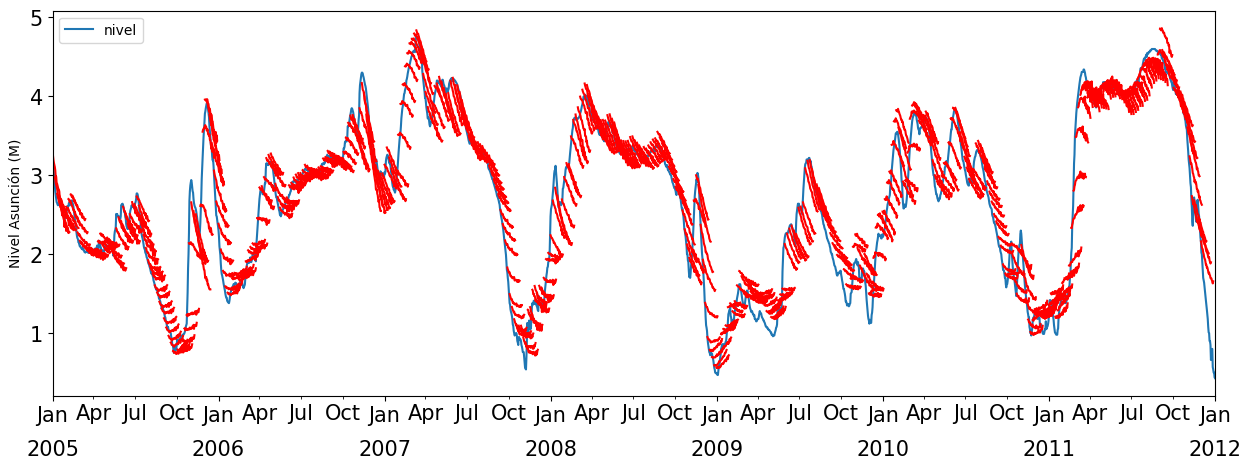

In [200]:

df = val[['nivel']][tamanio_ventana:]

# Se crea una figura f y el eje ax
f, ax = plt.subplots(figsize=(15, 5))

# Gráficos de líneas con datos de df y eje ax
sns.lineplot(data=df, ax=ax)

# Formato de fechas
# Objeto localizador coloca marcas menores cada 3 meses
fmt_month = mdates.MonthLocator(interval=3)
# Marcas cada año
fmt_year = mdates.YearLocator()

ax.xaxis.set_minor_locator(fmt_month)
# '%b' para obtener los nombres de los meses Muestra los meses como Ene, Feb ..
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Tamaño de fuente de las etiquetas de marcas
ax.tick_params(labelsize=15, which='both')

# Crear un segundo eje x debajo del primero para mostrar el año en formato YYYY
sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Ocultar las líneas y marcas del segundo eje x
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=15)

ax.set_ylabel('Nivel Asunción (M)')
ax.set_xlabel('')
ax.set_xlim(df.index[0], df.index[-1])

j = 0
mse = []
maxe = []
t = []

# El bucle itera sobre los valores predichos (Y_prediction) con un paso de horizonte.
for i in range(0, len(Y_prediction), horizonte):
    if (j % 5 == 0) and ((j + horizonte) < len(df)):  # Si j es divisible por 5 calcula mse, maxErr de
        # Los valores reales de df.nivel[j:(j + horizonte)]) y valores predichos Y_prediction[i:i + horizonte]
        mse.append(mean_squared_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        maxe.append(max_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        t.append(df.index[j])
        
        plt.plot(df.index[j:(j + horizonte)], Y_prediction[i:i + horizonte], color='red')
    j += 1
plt.show()


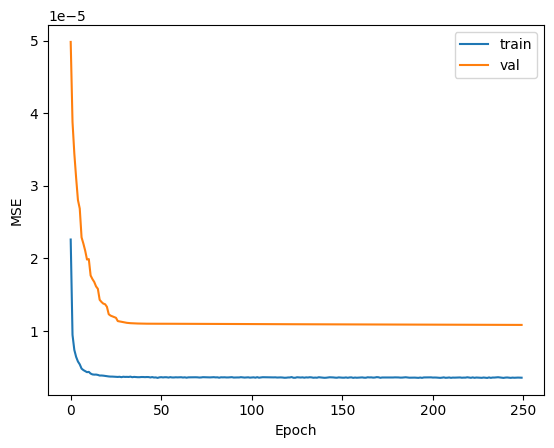

In [201]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

In [202]:
desde = (dt.datetime.strptime('2013-01-01', '%Y-%m-%d')- dt.timedelta(days=tamanio_ventana)).strftime('%Y/%m/%d') # Toma la fecha que se encuentra en el año '2018-01-01' hasta 'tamanio_ventana' días antes
test = datos_normm.loc[desde:'2022-01-01'] # Toma el conjunto de datos para la test
ix = test.index # Toma los indices del conjunto de datos de test
testScaler = MinMaxScaler()# Inicializa una normalización de 0 a 1 para el conjunto de datos de test
testScaler.fit(test) # Ajusta la normalización a los datos de test
testScaled = pd.DataFrame(testScaler.transform(test),columns=test.columns) # Crea un dataframe con el conjunto de datos de test normalizados y ajustados
testScaled.set_index(ix) # Agrega como indice la fecha al dataframe con los conjuntos de datos normalizados y ajustados
x_test, y_test = preparar_datos(tamanio_ventana,horizonte, testScaled) # Divide los datos de test

In [203]:
Y_prediction = testScaler.inverse_transform(np.hstack(((model.predict(x_test).reshape(-1, 1), np.zeros((np.size(y_test),nfeatures -1))))))[:, 0] # Predicción del modelo sobre los datos de test, y luego aplica una transformación inversa para delver los datos a su escala original
y_test_inv = testScaler.inverse_transform(np.hstack(((y_test.reshape(-1, 1), np.zeros((np.size(y_test),nfeatures -1))))))[:, 0] # Transformación inversa de 'y_test' a su escala original
mse = mean_squared_error( y_test_inv, Y_prediction) # Calculo del error cuadrático medio
mse = mean_squared_error( y_test_inv, Y_prediction) # Calculo del error cuadrático medio
rmse = np.sqrt(mse) # Calculo de la raíz del error cuadrático medio
maxError_ = max_error(y_test_inv, Y_prediction) # Error máximo entre y_test_inv e y y_prediction
r2_ = r2_score(y_test_inv, Y_prediction) # Calculo del coeficiente de determinación r cuadrado, que indica la proporción de la varianza en las etiquetas de test. Un valor cercano 1 indica un buen ajuste dell modelo 
nse = 1 - (np.sum((y_test_inv - Y_prediction) ** 2) / np.sum((y_test_inv - np.mean(y_test_inv)) ** 2)) # Cálculo de la metrica nse 
print( "MSE: " + str(mse)+" RMSE:" + str(rmse  )) # Muestra el MSE y RMSE
print( "MaxError: " + str(maxError_)+" R2:" + str(r2_  )) # Muestra maxError_ y R^2
print("NSE: " + str(nse)) # Muesta el NSE
end_time = time.time() # Registra el tiempo final desde la epoca
elapsed_time = end_time - start_time # Tiempo transcurrido entre epocas
print(f"Time step : {elapsed_time:.6f} seconds") # Muestra el tiempo transcurrido

102/102 [==============================] - 1s 13ms/step
MSE: 0.4164743724339909 RMSE:0.6453482567064011
MaxError: 4.183719946742058 R2:0.897923128657684
NSE: 0.897923128657684
Time step : 5807.503420 seconds


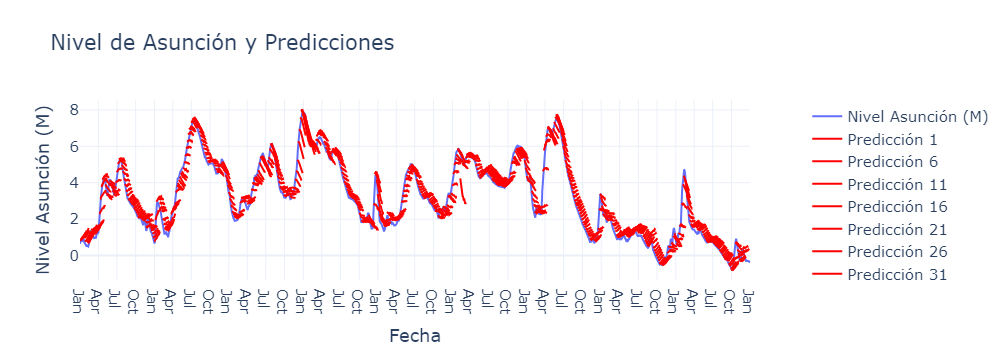

In [207]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from sklearn.metrics import mean_squared_error, max_error

# Definir el dataframe df y el conjunto de predicciones Y_prediction
# test = ... # Tu dataframe original
df = test[['nivel']][tamanio_ventana:]
# Y_prediction = ... # Tus predicciones
# horizonte = ... # El horizonte que estás usando para la predicción

# Crear figura con subplots para eje secundario
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Agregar línea de datos originales
fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['nivel'], 
    mode='lines', 
    name='Nivel Asunción (M)'
))

# Bucle para agregar líneas de predicciones
j = 0
mse = []
maxe = []
t = []

for i in range(0, len(Y_prediction), horizonte):
    if (j % 5 == 0) and ((j + horizonte) < len(df)):
        mse.append(mean_squared_error(np.array(df['nivel'][j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        maxe.append(max_error(np.array(df['nivel'][j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        t.append(df.index[j])

        fig.add_trace(go.Scatter(
            x=df.index[j:(j + horizonte)], 
            y=Y_prediction[i:i + horizonte], 
            mode='lines', 
            line=dict(color='red'), 
            name=f'Predicción {i//horizonte + 1}'
        ), secondary_y=False)
    j += 1

# Actualizar layout de la figura
fig.update_layout(
    title='Nivel de Asunción y Predicciones',
    xaxis_title='Fecha',
    yaxis_title='Nivel Asunción (M)',
    xaxis=dict(
        tickformat="%b",  # Formato de los meses
        tickmode='linear',
        dtick="M3"  # Cada 3 meses
    ),
    xaxis2=dict(
        tickformat="%Y",  # Formato del año
        overlaying='x',
        side='bottom',
        position=0.1,
        ticklen=0,
        showline=False
    ),
    template='plotly_white',
    font=dict(size=15)
)

# Mostrar figura
fig.show()

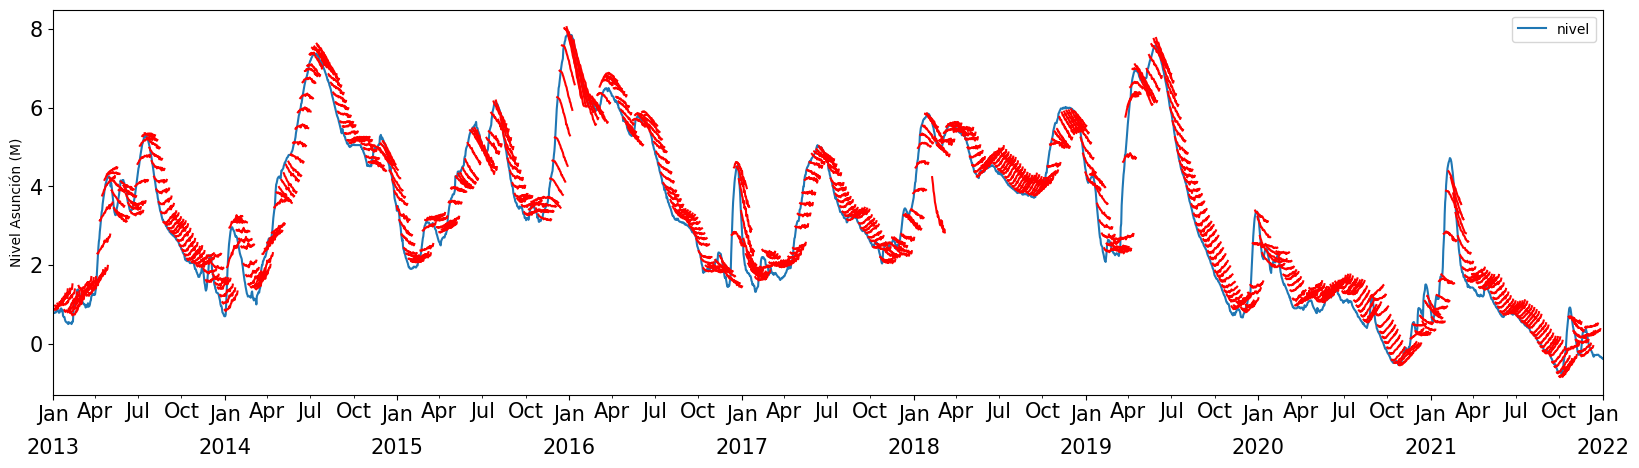

In [206]:
df = test[['nivel']][tamanio_ventana:]

# Se crea una figura f y el eje ax
f, ax = plt.subplots(figsize=(20, 5))

# Gráficos de líneas con datos de df y eje ax
sns.lineplot(data=df, ax=ax)

# Formato de fechas
# Objeto localizador coloca marcas menores cada 3 meses
fmt_month = mdates.MonthLocator(interval=3)
# Marcas cada año
fmt_year = mdates.YearLocator()

ax.xaxis.set_minor_locator(fmt_month)
# '%b' para obtener los nombres de los meses Muestra los meses como Ene, Feb ..
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Tamaño de fuente de las etiquetas de marcas
ax.tick_params(labelsize=15, which='both')

# Crear un segundo eje x debajo del primero para mostrar el año en formato YYYY
sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Ocultar las líneas y marcas del segundo eje x
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=15)

ax.set_ylabel('Nivel Asunción (M)')
ax.set_xlabel('')
ax.set_xlim(df.index[0], df.index[-1])

j = 0
mse = []
maxe = []
t = []

# El bucle itera sobre los valores predichos (Y_prediction) con un paso de horizonte.
for i in range(0, len(Y_prediction), horizonte):
    if (j % 5 == 0) and ((j + horizonte) < len(df)):  # Si j es divisible por 5 calcula mse, maxErr de
        # Los valores reales de df.nivel[j:(j + horizonte)]) y valores predichos Y_prediction[i:i + horizonte]
        mse.append(mean_squared_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        maxe.append(max_error(np.array(df.nivel[j:(j + horizonte)]), Y_prediction[i:i + horizonte]))
        t.append(df.index[j])
        
        plt.plot(df.index[j:(j + horizonte)], Y_prediction[i:i + horizonte], color='red')
    j += 1
plt.show()

In [ ]:
# Guardar el estudio
#with open("optuna_study.pkl", "wb") as f:
  #  dump(study, f)

# Cargar el estudio
#with open("optuna_study.pkl", "rb") as f:
   # study = load(f)

In [210]:
import seaborn as sns
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as dates
from matplotlib import dates as mdates
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300
rcParams["font.size"] = 16
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
sns.set_style("whitegrid")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
import optuna
from pickle import dump,load

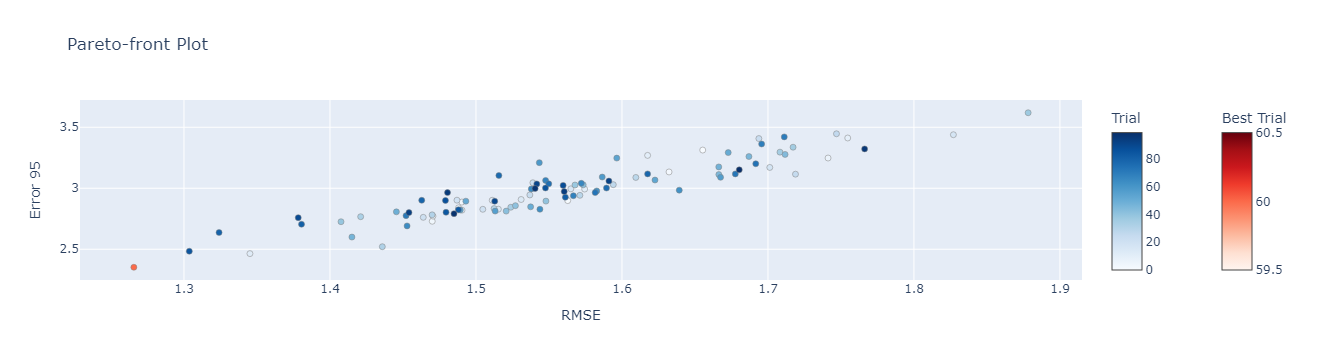

In [212]:
# Cargar el estudio de Optuna
study = load(open('optuna_study.pkl', 'rb'))

# Visualizar el frente de Pareto
fig = optuna.visualization.plot_pareto_front(study, target_names=["RMSE", "Error 95"])
fig.show()

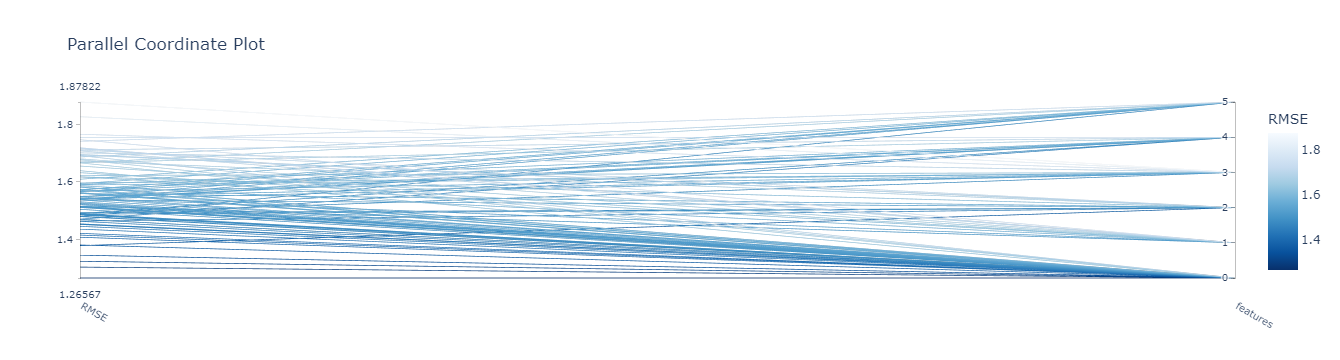

In [223]:
# Visualizar la importancia de los parámetros
#fig_param_importances = optuna.visualization.plot_param_importances(study,target=target, target_name="RMSE")
#fig_param_importances.show()
# Función para determinar el objetivo
def target(trial):
    return trial.values[0]  # Puedes cambiar el índice para el segundo objetivo si deseas

# Visualizar la coordenada paralela con el objetivo especificado
fig_parallel_coordinate = optuna.visualization.plot_parallel_coordinate(study, target=target, target_name="RMSE")
fig_parallel_coordinate.show()

In [1]:
fig=optuna.visualization.plot_param_importances(study, target=lambda t: t.values[0], target_name="Error 95")
fig.show()
fig=optuna.visualization.plot_param_importances(study, target=lambda t: t.values[1], target_name="RMSE")
fig.show()   

NameError: name 'optuna' is not defined